In [8]:
import warnings

from yellowbrick.cluster import KElbowVisualizer


pal = [(39/255,95/255,153/255),
       (80/255,176/255,220/255),
       (237/255,244/255,248/255),
       (146/255,144/255,142/255),
       (78/255,78/255,80/255),
        (235/255,154/255,88/255),
       (87/255,126/255,130/255)]

import sklearn.cluster
import sklearn_extra.cluster

import matplotlib.colors as mcolors
import umap.umap_ as umap
import phate
import sklearn.cluster
import numpy as np
import argparse
import cv2
from phate import cluster_custom
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import venn


from tqdm import tqdm
import sys
sys.path.append("/Users/rcarlson/Documents/GitHub/lasagna3/snakes")
import mahotas
from ops.imports_ipython import *

import skimage
import umap.umap_ as umap
import stringdb
import pandas as pd

from dask import compute, delayed
from dask.distributed import Client
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import igraph as ig
from sklearn.neighbors import kneighbors_graph

import leidenalg
import gseapy as gp

scaler = StandardScaler()
import magic

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

### Autoencoder Performancee


In [2]:
### Define true hits

lowhits = ['MAVS', 'DDX58', 'ATP13A1', 'RNF135', 'IRF3', 'IRF2', 'NCOR2', 'IKBKG',
           
           'SLC35A1','GNE','CMAS','ATP2B1','ADNP','LIN37','ACTR6', 'SEC61B',
           'COG7','KLHL15','CAPN15','PIP4K2C','PDS5A',
          'FBXO11','FBXW7','FZR1']


highhits = ['PRDM1', 'STAT3', 
            'PDCD10','MAP2K6','CCNC','MED13','MED24','MED16','BTAF1',
            'ALG1L2','DIS3L','POGZ','VPS11','VPS16','VPS39',
            'SEPHS1','CAB39','MAU2','AKIRIN1',
            'TADA2B','TAF5L','TAF6L',
            'FLCN','RRAGC','LAMTOR2','LAMTOR3','LAMTOR5'
           ]

defined = pd.read_csv('../Data/TableS3.csv')

truehits = lowhits + highhits
nothits = [g for g in defined[~(pd.isnull(defined.mean_transloc_secondary_antibody)) & ~(pd.isnull(defined.mean_transloc_secondary_reporter))].gene_symbol if g not in truehits]

negnothits = defined.loc[(defined.gene_symbol.isin(nothits)) & 
          (defined.mean_transloc_primary < 0)].gene_symbol
negtruehits = defined.loc[(defined.gene_symbol.isin(truehits)) & 
          (defined.mean_transloc_primary < 0)].gene_symbol
posnothits = defined.loc[(defined.gene_symbol.isin(nothits)) & 
          (defined.mean_transloc_primary > 0)].gene_symbol
postruehits = defined.loc[(defined.gene_symbol.isin(truehits)) & 
          (defined.mean_transloc_primary > 0)].gene_symbol

In [3]:
def grp_df(sg_df_loc):
    grped = pd.read_hdf(sg_df_loc)
    nt = grped[grped.gene == "nontargeting"]
    bcls = ([nt.cell_barcode_0[i:i + 3] for i in range(0, len(nt.cell_barcode_0), 3)])
    grped['gene_og'] = grped['gene']
    for i in range(len(bcls)):
        grped.loc[grped.cell_barcode_0.isin(bcls[i]),'gene'] = 'nontargeting_' + str(i)
    grped = grped.groupby(['gene','gene_og']).mean().reset_index()
    grped.reset_index(inplace = True)
    return grped

In [97]:
loc = '../../Zenodo_IRF3/DeepLearning/Transfer/Features/tf_df_feats_ch2_grped_sgonly.hdf'

transfer = grp_df(loc)
transfer = transfer[transfer.gene.isin(truehits + nothits)]
transfer.loc[transfer.gene.isin(nothits),'hit_status'] = 'not hit'
transfer.loc[transfer.gene.isin(negtruehits),'hit_status'] = 'neg'
transfer.loc[transfer.gene.isin(postruehits),'hit_status'] = 'pos'

loc = '../../Zenodo_IRF3/DeepLearning/Autoencoder/Features/ae_df_feats_ch2_grped_sgonly.hdf'

autoencoder = grp_df(loc)
autoencoder = autoencoder[autoencoder.gene.isin(truehits + nothits)]
autoencoder.loc[autoencoder.gene.isin(nothits),'hit_status'] = 'not hit'
autoencoder.loc[autoencoder.gene.isin(negtruehits),'hit_status'] = 'neg'
autoencoder.loc[autoencoder.gene.isin(postruehits),'hit_status'] = 'pos'

defined = defined[defined.gene_symbol.isin(transfer.gene)]
defined.loc[defined.gene_symbol.isin(nothits),'hit_status'] = 'not hit'
defined.loc[defined.gene_symbol.isin(negtruehits),'hit_status'] = 'neg'
defined.loc[defined.gene_symbol.isin(postruehits),'hit_status'] = 'pos'


In [103]:
## Train classifier defined
Xm = np.array(defined[defined.gene_symbol.isin(nothits + truehits)].mean_transloc_primary)[:,np.newaxis]
factor = pd.factorize(defined[defined.gene_symbol.isin(nothits + truehits)].hit_status)
defined['hit_status'] = factor[0]
defined.definitions = factor[1]
ym = defined.hit_status
X_train, X_test, y_train, y_test, gene_train, gene_test = train_test_split(Xm, ym, defined.gene_symbol, test_size=0.3, shuffle=True, 
                                                                           random_state = 8)

rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["defined"] = all_fpr
tpr["defined"] = mean_tpr
roc_auc["defined"] = auc(fpr["defined"], tpr["defined"])

## Train classifier transfer
factor = pd.factorize(transfer[transfer.gene.isin(nothits + truehits)].hit_status)
transfer['hit_status'] = factor[0]
transfertrain = transfer[transfer.gene.isin(gene_train)]
transfertest = transfer[transfer.gene.isin(gene_test)]
X_train = np.array(transfertrain.loc[:, transfer.columns.str.startswith('cnn')])
X_test = np.array(transfertest.loc[:, transfer.columns.str.startswith('cnn')])
y_train = transfertrain.hit_status
y_test = transfertest.hit_status


rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["transfer"] = all_fpr
tpr["transfer"] = mean_tpr
roc_auc["transfer"] = auc(fpr["transfer"], tpr["transfer"])

## Train classifier autoencoder
factor = pd.factorize(autoencoder[autoencoder.gene.isin(nothits + truehits)].hit_status)
autoencoder['hit_status'] = factor[0]
autoencodertrain = autoencoder[autoencoder.gene.isin(gene_train)]
autoencodertest = autoencoder[autoencoder.gene.isin(gene_test)]
X_train = np.array(autoencodertrain.loc[:, autoencoder.columns.str.startswith('ae')])
X_test = np.array(autoencodertest.loc[:, autoencoder.columns.str.startswith('ae')])
y_train = autoencodertrain.hit_status
y_test = autoencodertest.hit_status


rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["autoencoder"] = all_fpr
tpr["autoencoder"] = mean_tpr
roc_auc["autoencoder"] = auc(fpr["autoencoder"], tpr["autoencoder"])

## Train classifier combined

cnnmean = transfer.loc[:,transfer.columns.str.contains('feat')].mean(axis = 0).mean()
aemean = autoencoder.loc[:,autoencoder.columns.str.contains('feat')].mean(axis = 0).mean()
combined = pd.merge(transfer, autoencoder,on = 'gene')



factor = pd.factorize(combined[combined.gene.isin(nothits + truehits)].hit_status_x)
combined['hit_status'] = factor[0]
combinedtrain = combined[combined.gene.isin(gene_train)]
combinedtest = combined[combined.gene.isin(gene_test)]
X_train = np.array(combinedtrain.loc[:, combined.columns.str.contains('feat')])
X_test = np.array(combinedtest.loc[:, combined.columns.str.contains('feat')])
y_train = combinedtrain.hit_status
y_test = combinedtest.hit_status


rf = RandomForestClassifier(n_estimators = 1000, random_state = 7, max_depth = 100)
rf.fit(X_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)

n_classes = 3
# Compute ROC curve and ROC area for each class
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["combined"] = all_fpr
tpr["combined"] = mean_tpr
roc_auc["combined"] = auc(fpr["combined"], tpr["combined"])

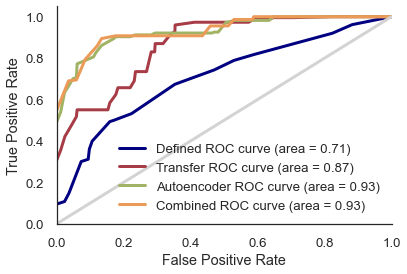

In [114]:
# Plot all ROC curves
lw = 3
sns.set(font_scale=1.2)
sns.set_style('white')


plt.figure(figsize = (6,4))

plt.plot(fpr["defined"], tpr["defined"],
         label='Defined ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["defined"]),
         color='navy', linewidth=lw)

plt.plot(fpr["transfer"], tpr["transfer"],
         label='Transfer ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["transfer"]),
         color=pal[0], linewidth=lw)

plt.plot(fpr["autoencoder"], tpr["autoencoder"],
         label='Autoencoder ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["autoencoder"]),
         color=pal[2], linewidth=lw)

plt.plot(fpr["combined"], tpr["combined"],
         label='Combined ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["combined"]),
         color=pal[4], linewidth=lw)

    
plt.plot([0, 1], [0, 1], 'lightgray', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
sns.despine(top = True, right = True)

plt.savefig('rf.tif',dpi=600,bbox_inches = 'tight')
plt.show()

In [191]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = rf.predict_proba(X_test)


## .2, rs 1

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


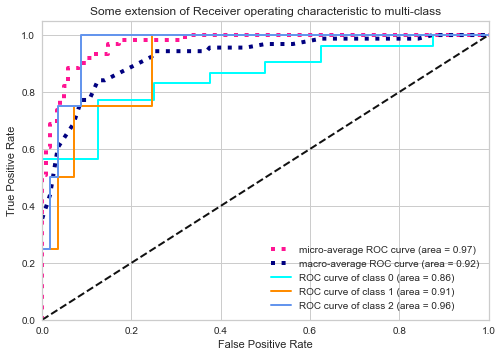

In [192]:


lw = 2

n_classes = 3

y_score = rf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


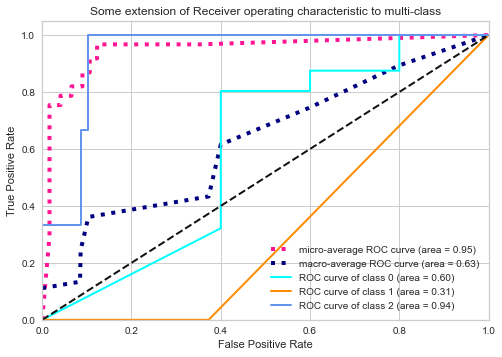

In [182]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

lw = 2

n_classes = 3

y_score = rf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [114]:
from sklearn.metrics import plot_roc_curve
rfc_disp = plot_roc_curve(rf, X_test, y_test, alpha=0.8)


ValueError: RandomForestRegressor should be a binary classifier

In [109]:
from sklearn.metrics import accuracy_score


# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
print("Accuracy on training set: {:.2f}%".format(accuracy_score(y_test, predictions) * 100))


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [91]:
parameters = {
    'min_samples_split': [20, 25, 30],
    'min_samples_leaf': [5, 8, 10],
    'max_leaf_nodes': [18, 19],
    'max_features': [2]
}

model = DecisionTreeClassifier(random_state=7)

clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

# Output [17]: GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             # param_grid={'max_features': [2], 'max_leaf_nodes': [18, 19],
                         # 'min_samples_leaf': [5, 8, 10],
                         # 'min_samples_split': [20, 25, 30]})
            
clf.best_estimator_
# Output [24]: DecisionTreeClassifier(max_features=2, max_leaf_nodes=18, min_samples_leaf=8, 
                                    # min_samples_split=20, random_state=42)

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/rcarlson/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  

ValueError: Expected 2D array, got 1D array instead:
array=[ 3.27229910e-02 -1.59291886e-02 -5.39500974e-02 -1.87594630e-02
  2.07318757e-02 -5.03995866e-02 -3.28307189e-02 -3.52289937e-02
  8.15976691e-03 -3.48084420e-02  3.55270319e-02  2.57875621e-02
 -3.50211449e-02 -5.83087318e-02  1.75120533e-02  3.78531124e-03
  1.90762077e-02  1.45895267e-02  4.26125452e-02 -7.38984719e-03
 -7.33496696e-02 -1.02505036e-01 -7.03880340e-02 -1.04607865e-02
 -3.77398506e-02 -5.46934865e-02 -8.51843730e-02 -7.22085610e-02
  4.79867496e-02 -9.29887667e-02  3.98144014e-02 -6.59380928e-02
  3.19831222e-02  4.31984998e-02  3.27452682e-02  7.07160681e-02
 -5.96326850e-02  3.84583846e-02 -3.30994558e-03  2.70179529e-02
  1.80877503e-02  1.07500879e-02  3.60753853e-03  6.46625459e-02
  1.22275008e-02 -6.19610474e-02  1.99503750e-02 -3.24919000e-02
  2.27926690e-02  4.34757471e-02  4.93969508e-02  3.04148551e-02
 -5.08145764e-02  4.26650494e-02  6.15179213e-03  4.18481119e-02
  3.57404724e-02  3.95732820e-02 -4.91235703e-02 -1.05468720e-01
 -1.55209124e-01 -1.66410878e-02  2.82539371e-02 -1.62937064e-02
 -2.49418672e-02 -1.27488941e-01  2.16316301e-02  1.73986256e-02
 -3.04632913e-02  4.88983989e-02 -4.55375575e-02 -5.89611642e-02
 -4.44966890e-02  4.18804735e-02 -7.16380626e-02 -4.54394817e-02
  2.78487895e-02 -3.09111141e-02 -4.17553186e-02  1.10378470e-02
 -7.54155517e-02  3.49332355e-02 -4.91564609e-02 -2.60222219e-02
 -1.61006153e-02 -7.47261643e-02 -5.61560914e-02 -4.86238040e-02
 -1.47991981e-02 -4.73684259e-02  1.44442758e-02 -3.39707807e-02
 -4.08449098e-02 -1.19538568e-02  4.85287681e-02 -4.43059653e-02
 -5.00563942e-02  2.71364339e-02 -5.47069088e-02  1.23034101e-02
 -3.72926407e-02 -7.04173818e-02 -7.66027421e-02 -4.65247817e-02
 -1.04186283e-02 -5.39226383e-02  5.53836375e-02 -7.08481967e-02
 -4.87069786e-02  5.55019900e-02 -5.50123490e-02 -3.57800685e-02
 -2.97648669e-03 -6.20955378e-02 -5.46030290e-02 -8.54528025e-02
 -1.17406733e-01 -2.22441945e-02 -4.37634923e-02  3.86710651e-02
  4.21686508e-02  9.49829258e-03 -8.36027712e-02 -2.16500908e-02
 -4.17422391e-02  1.62635576e-02  9.33424477e-03 -4.39901464e-02
  2.95601264e-02 -3.12908832e-03 -1.36093497e-02  8.15176666e-02
 -3.70039754e-02  9.12671257e-03 -1.62701178e-02  1.68320406e-02
 -7.57555850e-03  4.49024066e-02 -2.10573357e-02 -3.36420946e-02
  5.09703755e-02  3.10459714e-02  7.28924992e-03 -5.21828979e-02
  5.08827493e-02 -4.96179461e-02 -3.82887153e-03 -1.88829750e-02
  5.81314638e-02  7.09951073e-02  6.51877746e-02 -8.32186732e-03
 -1.27089605e-01 -2.13537104e-02 -5.87673895e-02  1.28967315e-03
 -1.06841205e-02  3.37412395e-02 -1.17416829e-02  5.05802892e-02
 -3.63123044e-02 -4.16773260e-02  5.23723364e-02  1.12232380e-03
  4.03835513e-02  1.02892928e-01 -4.56952527e-02 -1.30447629e-03
  9.12571885e-03 -5.80004826e-02  4.84492667e-02 -4.54312265e-02
 -5.38388565e-02 -7.69693181e-02 -1.94226298e-02 -1.15889823e-02
 -5.80190681e-03 -6.01663478e-02 -2.85603218e-02  3.81199270e-02
 -4.46238071e-02 -1.85880102e-02  3.90137322e-02 -3.24593745e-02
  2.75516473e-02 -2.44257320e-02 -5.01950793e-02  3.94185781e-02
  4.57938202e-02 -7.41519034e-02 -1.33805692e-01  1.34659116e-04
  2.57674493e-02  1.17080873e-02 -2.90741958e-02  3.33217718e-02
 -2.14729067e-02  5.75395953e-03  5.02321012e-02  1.77408662e-02
 -5.24522215e-02 -2.81961728e-02 -4.01543602e-02 -3.37755904e-02
  3.26552875e-02 -6.46578846e-03  1.88824125e-02  2.55187098e-02
 -1.74779426e-02 -4.58752289e-02 -3.20704803e-02 -1.10531813e-02
 -3.46781351e-02 -1.84066666e-04  5.86547107e-02 -3.93761769e-02
  5.55082448e-02 -4.55156751e-02  4.39301059e-02 -4.93864119e-02
  2.98161432e-02  5.90629317e-02 -4.62232046e-02  6.04591100e-04
 -4.30046208e-02  1.27896154e-02 -1.58731733e-03  1.41955307e-02
 -4.94070388e-02 -3.01069617e-02 -8.06279629e-02 -1.01145227e-02
  2.32179388e-02 -5.23225404e-02  1.56107582e-02  2.20496468e-02
 -1.35778310e-02 -1.17150452e-02 -2.43378747e-02  3.55617516e-02
 -7.28376582e-02 -2.63294466e-02 -1.72447432e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
y_pred_train = clf.predict(X_train)
print("Accuracy on training set: {:.2f}%".format(accuracy_score(y_train, y_pred_train) * 100))
y_pred_test = clf.predict(X_test)
print("Accuracy on test set: {:.2f}%".format(accuracy_score(y_test, y_pred_test) * 100))


In [38]:
nt = grped.loc[grped.gene.str.startswith('nontargeting'),grped.columns.str.contains('feat')].mean()

posnothitdist = grped.loc[grped.gene.isin(posnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

poshitdist = grped.loc[grped.gene.isin(postruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
posfargenestf = poshitdist.apply(lambda x: sum(posnothitdist < x))#.mean() 


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(X, y)

In [71]:
df

gene_symbol  fdr_bh_adj_p_primary  mean_transloc_primary  n_sg_primary  \
145          ACHE              0.074149              -0.019423           4.0   
157        ACOT11              0.037999               0.027136           3.0   
367          ADNP              0.000000              -0.035021           4.0   
405          AFF4              0.011090              -0.065938           4.0   
418         AGAP5              0.001536               0.064663           2.0   
...           ...                   ...                    ...           ...   
19507       ZNF43              0.004195              -0.022569           4.0   
19645      ZNF610              0.000000              -0.049407           4.0   
19683      ZNF667              0.000000              -0.024371           4.0   
19709      ZNF699              0.029440              -0.045431           4.0   
19748      ZNF740              0.122151               0.035562           4.0   

       fdr_bh_adj_p_secondary_reporter  mean_transloc_secondary_reporter  \
145                           0.278995                          0.003635   
157                           0.065055                          0.002593   
367                           0.000690                         -0.044930   
405                           0.950664                         -0.008518   
418                           0.806657                         -0.009076   
...                                ...                               ...   
19507                         0.917917                         -0.012126   
19645                         0.849199                         -0.007722   
19683                         0.917917                         -0.007451   
19709                         0.165417                         -0.025803   
19748                         0.065995                          0.017102   

       n_sg_secondary_reporter  fdr_bh_adj_p_secondary_antibody  \
145                        5.0                         0.833136   
157                        6.0                         0.856027   
367                        6.0                         0.001093   
405                        6.0                         0.268983   
418                        5.0                         0.010866   
...                        ...                              ...   
19507                      6.0                         0.844580   
19645                      5.0                         0.998401   
19683                      6.0                         0.957638   
19709                      6.0                         0.000031   
19748                      6.0                         0.478192   

       mean_transloc_secondary_antibody  fdr_bh_adj_p_sev_cell_median  \
145                            0.002616                      0.016555   
157                            0.001831                      0.371305   
367                           -0.028913                      0.581445   
405                           -0.006462                      0.701270   
418                            0.006021                      0.778169   
...                                 ...                           ...   
19507                          0.007519                      0.970058   
19645                          0.005113                      0.994120   
19683                          0.004516                      0.202706   
19709                         -0.032013                      0.123592   
19748                          0.014550                      0.000011   

       mean_sev_cell_median  n_sg_secondary_antibody hit status  
145               -0.006424                      4.0    not hit  
157                0.008235                      6.0    not hit  
367               -0.003969                      5.0        neg  
405                0.005951                      6.0    not hit  
418               -0.001080                      4.0    not hit  
...                     ...                      ...  

In [93]:
pd.get_dummies(df.hit_status)

labels = np.array(features['actual'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('actual', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)


neg  not hit  pos
145      0        1    0
157      0        1    0
367      1        0    0
405      0        1    0
418      0        1    0
...    ...      ...  ...
19507    0        1    0
19645    0        1    0
19683    0        1    0
19709    0        1    0
19748    0        1    0

[304 rows x 3 columns]

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
>>> clf = RandomForestClassifier(max_depth=2, random_state=0)
>>> clf.fit(X, y)

496      0.275879
1613     0.282959
2195     0.323730
2610     0.748047
3408     0.252686
5685     0.274414
8393     0.211914
8394     0.273438
8396     0.144897
9656     0.404053
9755     0.209961
9854     0.246460
9859     0.336914
9865     0.318604
12143    0.322510
12704    0.246704
12953    0.348145
14106    0.170776
14490    0.174561
15777    0.265625
16043    0.402100
16058    0.340332
16059    0.325439
17829    0.503906
17834    0.232910
17847    0.333252
dtype: float64

In [ ]:
design = pd.read_csv("/Users/rcarlson/Documents/lasagna_d/MAVS/poolm0_design_L1.csv")


loc = '../Data/m40-m42-transfer/tf_df_feats_ch2_grped_sgonly.hdf'
grped = grp_df(loc)
smallnothits = grped.loc[grped.gene.isin(nothits)].gene
smalltruehits = grped.loc[grped.gene.isin(truehits)].gene
#grped.loc[:,grped.columns.str.contains('feat')] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.contains('feat')])

nt = grped.loc[grped.gene.str.startswith('nontargeting'),grped.columns.str.contains('feat')].mean()
nothitdist = grped.loc[grped.gene.isin(nothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

hitdist = grped.loc[grped.gene.isin(truehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
fargenestf = hitdist.apply(lambda x: sum(nothitdist < x))#.mean() 
## average genes at a greater distance from NT than true hits, perfect would be 276

posnothitdist = grped.loc[grped.gene.isin(posnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

poshitdist = grped.loc[grped.gene.isin(postruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
posfargenestf = poshitdist.apply(lambda x: sum(posnothitdist < x))#.mean() 


negnothitdist = grped.loc[grped.gene.isin(negnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

neghitdist = grped.loc[grped.gene.isin(negtruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
negfargenestf = neghitdist.apply(lambda x: sum(negnothitdist < x))#.mean() 


loc = '../Data/m40-m42-ae/ae_df_feats_ch2_grped_sgonly.hdf'
grped = grp_df(loc)
#grped.loc[:,grped.columns.str.contains('feat')] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.contains('feat')])

nt = grped.loc[grped.gene.str.startswith('nontargeting'),grped.columns.str.contains('feat')].mean()
nothitdist = grped.loc[grped.gene.isin(nothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

hitdist = grped.loc[grped.gene.isin(truehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
fargenesae = hitdist.apply(lambda x: sum(nothitdist < x))#.mean() 

posnothitdist = grped.loc[grped.gene.isin(posnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

poshitdist = grped.loc[grped.gene.isin(postruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
posfargenesae = poshitdist.apply(lambda x: sum(posnothitdist < x))#.mean() 

negnothitdist = grped.loc[grped.gene.isin(negnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

neghitdist = grped.loc[grped.gene.isin(negtruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
negfargenesae = neghitdist.apply(lambda x: sum(negnothitdist < x))#.mean() 



In [ ]:

grped = pd.read_pickle('../Data/m40-m42/grped_final.pkl')
#nt = grped.loc[grped.index.str.startswith('nontargeting'),'mean_dapi_corrch2_nuclear_corr']#.mean()
#grped.columns
negnothits = grped.loc[(grped.index.isin(smallnothits)) & 
          (grped['mean_dapi_corrch2_nuclear_corr'] > 0)].index
negtruehits = grped.loc[(grped.index.isin(smalltruehits)) & 
          (grped['mean_dapi_corrch2_nuclear_corr'] > 0)].index
posnothits = grped.loc[(grped.index.isin(smallnothits)) & 
          (grped['mean_dapi_corrch2_nuclear_corr'] < 0)].index
postruehits = grped.loc[(grped.index.isin(smalltruehits)) & 
          (grped['mean_dapi_corrch2_nuclear_corr'] < 0)].index


nothitdist = grped.loc[grped.index.isin(smallnothits),
          'mean_dapi_corrch2_nuclear_corr']

hitdist = grped.loc[grped.index.isin(smalltruehits),
         'mean_dapi_corrch2_nuclear_corr']
fargenesdef = hitdist.apply(lambda x: sum(nothitdist < x))#.mean()


posnothitdist = grped.loc[grped.index.isin(posnothits),
          'mean_dapi_corrch2_nuclear_corr']

poshitdist = grped.loc[grped.index.isin(postruehits),
         'mean_dapi_corrch2_nuclear_corr']
posfargenesdef = poshitdist.apply(lambda x: sum(posnothitdist < x))#.mean()

negnothitdist = grped.loc[grped.index.isin(negnothits),
          'mean_dapi_corrch2_nuclear_corr']

neghitdist = grped.loc[grped.index.isin(negtruehits),
         'mean_dapi_corrch2_nuclear_corr']
negfargenesdef = neghitdist.apply(lambda x: sum(negnothitdist < x))#.mean()




##### define functions

In [7]:
def grp_df(sg_df_loc):
    grped = pd.read_hdf(sg_df_loc)
    nt = grped[grped.gene == "nontargeting"]
    bcls = ([nt.cell_barcode_0[i:i + 3] for i in range(0, len(nt.cell_barcode_0), 3)])
    grped['gene_og'] = grped['gene']
    for i in range(len(bcls)):
        grped.loc[grped.cell_barcode_0.isin(bcls[i]),'gene'] = 'nontargeting_' + str(i)
    grped = grped.groupby(['gene','gene_og']).mean().reset_index()

    df = pd.read_hdf('../Data/m40-m42-transfer/df_grped_30cells_2sg.hdf')
    grped = pd.merge(grped, df, left_on = 'gene_og', right_index = True, how = 'inner')
    grped.reset_index(inplace = True)
    return grped

def calc_phate(df, colstart):
    phate_op = phate.PHATE(n_components = 10, n_jobs = -1, random_state = 7, knn = 5, t = 10, gamma = 0) 
    dfphate = phate_op.fit_transform(df.loc[:,df.columns.str.startswith(colstart)])
    return dfphate, phate_op

def phate_cluster(phate_op, n_clust):
    phate_clust = phate.cluster_custom.kmeans(phate_op, n_clusters = n_clust, random_state = 7)
    return phate_clust

def calc_umap(df, colstart):
    
    scaler = StandardScaler()
    pca = PCA(n_components = 100, svd_solver='full')
    pcs = pca.fit_transform(df.loc[:,df.columns.str.startswith(colstart)])

    dfumap = umap.UMAP(n_neighbors=5,
                          min_dist=0,
                          metric='euclidean', random_state = 7).fit_transform(pcs) # 
    return dfumap

def umap_cluster(df, n_clust, colstart):
    umap_clust = (sklearn.cluster.MiniBatchKMeans(n_clusters = n_clust, 
                                                  n_init = 100, max_iter = 1000, random_state = 7)
                    .fit(df.loc[:,df.columns.str.startswith(colstart)]))
    return umap_clust

def umap_cluster_contains(df, n_clust, colcontains):
    umap_clust = (sklearn.cluster.MiniBatchKMeans(n_clusters = n_clust, 
                                                  n_init = 100, max_iter = 1000, random_state = 7)
                    .fit(df.loc[:,df.columns.str.contains(colcontains)]))
    return umap_clust
    
def plot_umap_enrichr(loc, dfumap, n_clust, colstart, feature, name):
    
    grped = grp_df(loc)
    umap_clust = umap_cluster(grped, n_clust, colstart)
    dfu = pd.concat([pd.DataFrame(dfumap[:,:2]),grped,pd.Series(umap_clust.labels_)],axis = 1)
    dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + ['cluster']
    clustdist = dfu.groupby('cluster')[feature].mean().sort_values()[:1] + dfu.groupby('cluster')[feature].mean().sort_values()[-1:]
#     plt.figure(figsize = (6,6))
#     sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', hue = 'cluster', palette = 'Set3')

    plt.figure(figsize = (6,6))
    sns.scatterplot(data = dfu, x = 'UMAP1', 
                        y = 'UMAP2', color = mcolors.to_rgba('#d3d3d3'))
    low = clustdist.index[0] 
    low2 = clustdist.index[1] 
#     low3 = clustdist.index[2] 
#     low4 = clustdist.index[3]
#     low5 = clustdist.index[4]
#     low6 = clustdist.index[5]
    sns.scatterplot(data = dfu.query('cluster == @low'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[1])
    sns.scatterplot(data = dfu.query('cluster == @low2'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[0])
#     sns.scatterplot(data = dfu.query('cluster == @low3'), x = 'UMAP1', 
#                         y = 'UMAP2', color = pal[2])
#     sns.scatterplot(data = dfu.query('cluster == @low4'), x = 'UMAP1', 
#                         y = 'UMAP2', color = pal[3])
#     sns.scatterplot(data = dfu.query('cluster == @low5'), x = 'UMAP1', 
#                         y = 'UMAP2', color = pal[5])
#     sns.scatterplot(data = dfu.query('cluster == @low6'), x = 'UMAP1', 
#                         y = 'UMAP2', color = 'm')
    sns.scatterplot(data = dfu.query('gene_og == "nontargeting"'), x = 'UMAP1', 
                        y = 'UMAP2',
                    color = mcolors.to_rgba('#404040'))
    sns.despine(top = True, right = True)
    plt.show()

#     plt.figure(figsize = (6,6))
#     plt.scatter(data = dfu, x = 'UMAP1',  y = 'UMAP2', c = feature, vmin = -.8, vmax = .8)
#     plt.colorbar()
#     plt.xlabel('UMAP1')
#     plt.ylabel('UMAP2')
#     plt.show()
    
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Cellular_Component_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Molecular_Function_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library Reactome_2016 when cutoff = 0.05")

    for k in clustdist.index: 
        genes = list(dfu[dfu.cluster == k].gene)
        enr = gp.enrichr(gene_list=pd.Series(pd.unique(genes)),
                         gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                                   'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                         organism='Human', 
                         outdir='../Data/m40-m42-ae/moreenrichr/%s_umap_nclust%s_enrichr_cluster_%s'%(name,n_clust,k),
                         cutoff=0.05)
    return dfu
    
def plot_phate_enrichr(loc, dfphate, opphate, n_clust, colstart, feature, name):

    grped = grp_df(loc)
    phate_clust = phate_cluster(opphate, n_clust)
    dfu = pd.concat([pd.DataFrame(dfphate[:,:2]),grped,pd.Series(phate_clust)],axis = 1)
    dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + ['cluster']
    clustdist = dfu.groupby('cluster')[feature].mean().sort_values()[:3] + dfu.groupby('cluster')[feature].mean().sort_values()[-3:]
#     plt.figure(figsize = (6,6))
#     sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', hue = 'cluster', palette = 'Set3')

    plt.figure(figsize = (6,6))
    sns.scatterplot(data = dfu, x = 'UMAP1', 
                        y = 'UMAP2', color = mcolors.to_rgba('#d3d3d3'))
    low = clustdist.index[0] 
    low2 = clustdist.index[1] 
    low3 = clustdist.index[2] 
    low4 = clustdist.index[3]
    low5 = clustdist.index[4]
    low6 = clustdist.index[5]
    sns.scatterplot(data = dfu.query('cluster == @low'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[1])
    sns.scatterplot(data = dfu.query('cluster == @low2'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[0])
    sns.scatterplot(data = dfu.query('cluster == @low3'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[2])
    sns.scatterplot(data = dfu.query('cluster == @low4'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[3])
    sns.scatterplot(data = dfu.query('cluster == @low5'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[5])
    sns.scatterplot(data = dfu.query('cluster == @low6'), x = 'UMAP1', 
                        y = 'UMAP2', color = 'm')
    sns.scatterplot(data = dfu.query('gene_og == "nontargeting"'), x = 'UMAP1', 
                        y = 'UMAP2',
                    color = mcolors.to_rgba('#404040'))
    sns.despine(top = True, right = True)
    plt.show()

#     plt.figure(figsize = (6,6))
#     plt.scatter(data = dfu, x = 'UMAP1',  y = 'UMAP2', c = feature, vmin = -.8, vmax = .8)
#     plt.colorbar()
#     plt.xlabel('UMAP1')
#     plt.ylabel('UMAP2')
#     plt.show()
    
    
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Cellular_Component_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Molecular_Function_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", 
                            message="Warning: No enrich terms using library Reactome_2016 when cutoff = 0.05")


    ##

    for k in clustdist.index: 
        genes = list(dfu[dfu.cluster == k].gene)
        enr = gp.enrichr(gene_list=list(pd.unique(genes)),
                         gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                                   'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                         organism='Human', 
                         outdir='../Data/m40-m42-ae/moreenrichr/%s_phate_nclust%s_enrichr_cluster_%s'%(name,n_clust,k),
                         cutoff=0.05)
    return dfu
    
def plot_phate_enrichr_clustogdata(loc, dfphate, n_clust, colstart, feature, name):

    grped = grp_df(loc)
    clust = umap_cluster(grped, n_clust, colstart)
    dfu = pd.concat([pd.DataFrame(dfphate[:,:2]),grped,pd.Series(clust.labels_)],axis = 1)
    dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + ['cluster']
    clustdist = dfu.groupby('cluster')[feature].mean().sort_values()[:1] + dfu.groupby('cluster')[feature].mean().sort_values()[-1:]
#     plt.figure(figsize = (6,6))
#     sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', hue = 'cluster', palette = 'Set3')

    plt.figure(figsize = (6,6))
    sns.scatterplot(data = dfu, x = 'UMAP1', 
                        y = 'UMAP2', color = mcolors.to_rgba('#d3d3d3'))
    low = clustdist.index[0] 
    low2 = clustdist.index[1] 
#     low3 = clustdist.index[2] 
#     low4 = clustdist.index[3]
#     low5 = clustdist.index[4]
#     low6 = clustdist.index[5]
    sns.scatterplot(data = dfu.query('cluster == @low'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[1])
    sns.scatterplot(data = dfu.query('cluster == @low2'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[0])
#     sns.scatterplot(data = dfu.query('cluster == @low3'), x = 'UMAP1', 
#                         y = 'UMAP2', color = pal[2])
#     sns.scatterplot(data = dfu.query('cluster == @low4'), x = 'UMAP1', 
#                         y = 'UMAP2', color = pal[3])
#     sns.scatterplot(data = dfu.query('cluster == @low5'), x = 'UMAP1', 
#                         y = 'UMAP2', color = pal[5])
#     sns.scatterplot(data = dfu.query('cluster == @low6'), x = 'UMAP1', 
#                         y = 'UMAP2', color = 'm')
    sns.scatterplot(data = dfu.query('gene_og == "nontargeting"'), x = 'UMAP1', 
                        y = 'UMAP2',
                    color = mcolors.to_rgba('#404040'))
    sns.despine(top = True, right = True)
    plt.show()

#     plt.figure(figsize = (6,6))
#     plt.scatter(data = dfu, x = 'UMAP1',  y = 'UMAP2', c = feature, vmin = -.8, vmax = .8)
#     plt.colorbar()
#     plt.xlabel('UMAP1')
#     plt.ylabel('UMAP2')
#     plt.show()
    
    
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Cellular_Component_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Molecular_Function_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", 
                            message="Warning: No enrich terms using library Reactome_2016 when cutoff = 0.05")


    ##

    for k in clustdist.index: 
        genes = list(dfu[dfu.cluster == k].gene)
        enr = gp.enrichr(gene_list=list(pd.unique(genes)),
                         gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                                   'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                         organism='Human', 
                         outdir='../Data/m40-m42-ae/enrichrmixed/%s_phate_nclust%s_enrichr_cluster_%s'%(name,n_clust,k),
                         cutoff=0.05)
        
    return dfu
        

def plot_phate_enrichr_clustogdata_defineclusters(loc, dfphate, n_clust, colstart, feature, name, clusters):

    grped = grp_df(loc)
    clust = umap_cluster(grped, n_clust, colstart)
    dfu = pd.concat([pd.DataFrame(dfphate[:,:2]),grped,pd.Series(clust.labels_)],axis = 1)
    dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + ['cluster']
    #clustdist = dfu.groupby('cluster')[feature].mean().sort_values()[:3] + dfu.groupby('cluster')[feature].mean().sort_values()[-3:]
#     plt.figure(figsize = (6,6))
#     sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', hue = 'cluster', palette = 'Set3')

    plt.figure(figsize = (6,6))
    sns.scatterplot(data = dfu, x = 'UMAP1', 
                        y = 'UMAP2', color = mcolors.to_rgba('#d3d3d3'))
    low = clusters[0]
    sns.scatterplot(data = dfu.query('cluster == @low'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[1])    
    if len(clusters) > 1:
        low2 = clusters[1]
        sns.scatterplot(data = dfu.query('cluster == @low2'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[0])
    if len(clusters) > 2:
        low3 = clusters[2]
        sns.scatterplot(data = dfu.query('cluster == @low3'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[2])
    if len(clusters) > 3:
        low4 = clusters[3]
        sns.scatterplot(data = dfu.query('cluster == @low4'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[3])
    if len(clusters) > 4:
        low5 = clusters[4]
        sns.scatterplot(data = dfu.query('cluster == @low5'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[5])
    if len(clusters) > 5:
        low6 = clusters[5]
        sns.scatterplot(data = dfu.query('cluster == @low6'), x = 'UMAP1', 
                        y = 'UMAP2', color = 'm')

#     sns.scatterplot(data = dfu[dfu.gene.isin(['SLC35A1','GNE','CMAS'])], x = 'UMAP1', 
#                         y = 'UMAP2',
#                     color = 'c')
    sns.scatterplot(data = dfu.query('gene_og == "nontargeting"'), x = 'UMAP1', 
                        y = 'UMAP2',
                    color = mcolors.to_rgba('#404040'))
    sns.despine(top = True, right = True)
    plt.show()

#     plt.figure(figsize = (6,6))
#     plt.scatter(data = dfu, x = 'UMAP1',  y = 'UMAP2', c = feature, vmin = -.8, vmax = .8)
#     plt.colorbar()
#     plt.xlabel('UMAP1')
#     plt.ylabel('UMAP2')
#     plt.show()
    
    
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Cellular_Component_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Molecular_Function_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", 
                            message="Warning: No enrich terms using library Reactome_2016 when cutoff = 0.05")


    ##

    for k in clusters: 
        genes = list(dfu[dfu.cluster == k].gene)
        enr = gp.enrichr(gene_list=list(pd.unique(genes)),
                         gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                                   'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                         organism='Human', 
                         outdir='../Data/m40-m42-ae/enrichrmixed/DEFINED_%s_phate_nclust%s_enrichr_cluster_%s'%(name,n_clust,k),
                         cutoff=0.05)
    return dfu
        

def plot_phate_enrichr_clustogdata_multi(loc1, loc2, dfphate, n_clust, colcontains, feature, name):

    grped1 = grp_df(loc1)
    grped2 = grp_df(loc2)
    grped = pd.merge(grped1,grped2,on = 'gene')
    clust = umap_cluster_contains(grped, n_clust, colcontains)
    dfu = pd.concat([pd.DataFrame(dfphate[:,:2]),grped,pd.Series(clust.labels_)],axis = 1)
    dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + ['cluster']
    clustdist = dfu.groupby('cluster')[feature].mean().sort_values()[:4] + dfu.groupby('cluster')[feature].mean().sort_values()[-4:]
#     plt.figure(figsize = (6,6))
#     sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', hue = 'cluster', palette = 'Set3')

    plt.figure(figsize = (6,6))
    sns.scatterplot(data = dfu, x = 'UMAP1', 
                        y = 'UMAP2', color = mcolors.to_rgba('#d3d3d3'))
    low = clustdist.index[0] 
    low2 = clustdist.index[1] 
    low3 = clustdist.index[2] 
    low4 = clustdist.index[3]
    low5 = clustdist.index[4]
    low6 = clustdist.index[5]
    low7 = clustdist.index[6]
    low8 = clustdist.index[7]
    sns.scatterplot(data = dfu.query('cluster == @low'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[1])
    sns.scatterplot(data = dfu.query('cluster == @low2'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[0])
    sns.scatterplot(data = dfu.query('cluster == @low3'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[2])
    sns.scatterplot(data = dfu.query('cluster == @low4'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[3])
    sns.scatterplot(data = dfu.query('cluster == @low5'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[5])
    sns.scatterplot(data = dfu.query('cluster == @low6'), x = 'UMAP1', 
                        y = 'UMAP2', color = 'm')
    sns.scatterplot(data = dfu.query('cluster == @low7'), x = 'UMAP1', 
                        y = 'UMAP2', color = 'c')
    sns.scatterplot(data = dfu.query('cluster == @low8'), x = 'UMAP1', 
                        y = 'UMAP2', color = 'r')
    sns.scatterplot(data = dfu.query('gene_og_x == "nontargeting"'), x = 'UMAP1', 
                        y = 'UMAP2',
                    color = mcolors.to_rgba('#404040'))
    sns.despine(top = True, right = True)
    plt.show()


    for k in clustdist.index: 
        genes = list(dfu[dfu.cluster == k].gene)
        enr = gp.enrichr(gene_list=list(pd.unique(genes)),
                         gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                                   'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                         organism='Human', 
                         outdir='../Data/m40-m42-ae/enrichrmixed/%s_phate_multi_nclust%s_enrichr_cluster_%s'%(name,n_clust,k),
                         cutoff=0.05)   
    return dfu

def plot_phate_enrichr_clustogdata_multi_scaled(loc1, loc2, dfphate, colcontains, feature, name):

    grped1 = grp_df(loc1)
    grped2 = grp_df(loc2)
    grped = pd.merge(grped1,grped2,on = 'gene')
    grped.loc[:,grped.columns.str.contains(colcontains)] = StandardScaler().fit_transform(    grped.loc[:,grped.columns.str.contains(colcontains)] )
    #clust = umap_cluster_contains(grped, n_clust, colcontains)
    dfu = pd.concat([pd.DataFrame(dfphate[:,:2]),grped,pd.Series(clust.labels_)],axis = 1)
    dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + ['cluster']
    clustdist = dfu.groupby('cluster')[feature].mean().sort_values()[:4] + dfu.groupby('cluster')[feature].mean().sort_values()[-4:]
#     plt.figure(figsize = (6,6))
#     sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', hue = 'cluster', palette = 'Set3')

    plt.figure(figsize = (6,6))
    sns.scatterplot(data = dfu, x = 'UMAP1', 
                        y = 'UMAP2', color = mcolors.to_rgba('#d3d3d3'))
    low = clustdist.index[0] 
    low2 = clustdist.index[1] 
    low3 = clustdist.index[2] 
    low4 = clustdist.index[3]
    low5 = clustdist.index[4]
    low6 = clustdist.index[5]
    low7 = clustdist.index[6]
    low8 = clustdist.index[7]
    sns.scatterplot(data = dfu.query('cluster == @low'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[1])
    sns.scatterplot(data = dfu.query('cluster == @low2'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[0])
    sns.scatterplot(data = dfu.query('cluster == @low3'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[2])
    sns.scatterplot(data = dfu.query('cluster == @low4'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[3])
    sns.scatterplot(data = dfu.query('cluster == @low5'), x = 'UMAP1', 
                        y = 'UMAP2', color = pal[5])
    sns.scatterplot(data = dfu.query('cluster == @low6'), x = 'UMAP1', 
                        y = 'UMAP2', color = 'm')
    sns.scatterplot(data = dfu.query('cluster == @low7'), x = 'UMAP1', 
                        y = 'UMAP2', color = 'c')
    sns.scatterplot(data = dfu.query('cluster == @low8'), x = 'UMAP1', 
                        y = 'UMAP2', color = 'r')
    sns.scatterplot(data = dfu.query('gene_og_x == "nontargeting"'), x = 'UMAP1', 
                        y = 'UMAP2',
                    color = mcolors.to_rgba('#404040'))
    sns.despine(top = True, right = True)
    plt.show()


    for k in clustdist.index: 
        genes = list(dfu[dfu.cluster == k].gene)
        enr = gp.enrichr(gene_list=list(pd.unique(genes)),
                         gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                                   'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                         organism='Human', 
                         outdir='../Data/m40-m42-ae/enrichrmixed/%s_SCALED_phate_multi_nclust%s_enrichr_cluster_%s'%(name,n_clust,k),
                         cutoff=0.05)   
    return dfu


def plot_phate_enrichr_definedgenes(loc, dfphate, geneslow, geneshigh, name):

    grped = grp_df(loc)
    #clust = umap_cluster(grped, n_clust, colstart)
    dfu = pd.concat([pd.DataFrame(dfphate[:,:2]),grped],axis = 1)
    dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
    #clustdist = dfu.groupby('cluster')[feature].mean().sort_values()[:1] + dfu.groupby('cluster')[feature].mean().sort_values()[-1:]
#     plt.figure(figsize = (6,6))
#     sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', hue = 'cluster', palette = 'Set3')

    plt.figure(figsize = (6,6))
    sns.scatterplot(data = dfu, x = 'UMAP1', 
                        y = 'UMAP2', color = mcolors.to_rgba('#d3d3d3'))
   
    sns.scatterplot(data = dfu[dfu.gene.isin(geneslow)], x = 'UMAP1', 
                        y = 'UMAP2', color = pal[1])
    sns.scatterplot(data = dfu[dfu.gene.isin(geneshigh)], x = 'UMAP1', 
                        y = 'UMAP2', color = pal[0])
#     sns.scatterplot(data = dfu.query('cluster == @low3'), x = 'UMAP1', 
#                         y = 'UMAP2', color = pal[2])
#     sns.scatterplot(data = dfu.query('cluster == @low4'), x = 'UMAP1', 
#                         y = 'UMAP2', color = pal[3])
#     sns.scatterplot(data = dfu.query('cluster == @low5'), x = 'UMAP1', 
#                         y = 'UMAP2', color = pal[5])
#     sns.scatterplot(data = dfu.query('cluster == @low6'), x = 'UMAP1', 
#                         y = 'UMAP2', color = 'm')
    sns.scatterplot(data = dfu.query('gene_og == "nontargeting"'), x = 'UMAP1', 
                        y = 'UMAP2',
                    color = mcolors.to_rgba('#404040'))
    sns.despine(top = True, right = True)
    plt.show()

    
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Cellular_Component_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", message="Warning: No enrich terms using library GO_Molecular_Function_2018 when cutoff = 0.05")
    warnings.filterwarnings("ignore", 
                            message="Warning: No enrich terms using library Reactome_2016 when cutoff = 0.05")


    ##
    i = 0
    fnames = ['low', 'high']
    for genes in [geneslow, geneshigh]:
        k = fnames[i]
        i += 1
        #genes = list(dfu[dfu.cluster == k].gene)
        enr = gp.enrichr(gene_list=list(pd.unique(genes)),
                         gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                                   'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                         organism='Human', 
                         outdir='../Data/m40-m42-ae/enrichrmixed/%s_phate_defined_enrichr_cluster_%s'%(name,k),
                         cutoff=0.05)
        
    return dfu
        

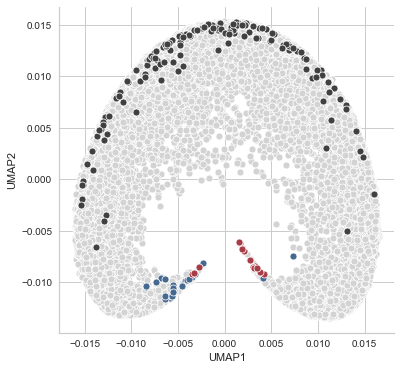

In [307]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch5_grped_sgonly_goodcells.hdf'
topn = 25
meanthresh = .15
colstart = 'cnn'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped,pd.DataFrame(gop_pex_tf.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_tf.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

tfup=dfu.query('mito_cell_median > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
tfdown=dfu.query('mito_cell_median < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-transfer/tf_df_feats_ch5_grped_sgonly_goodcells.hdf'
gmito_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_mito_tf, name = 'mito_tf_defined',
                                                      geneslow = tfdown, geneshigh = tfup)

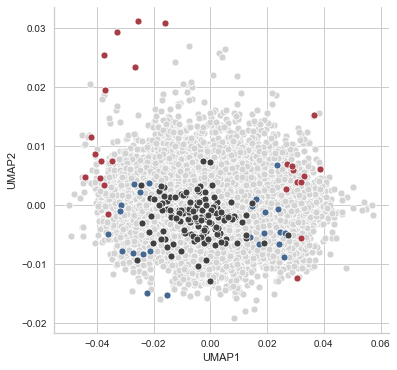

In [309]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch5_grped_sgonly_goodcells.hdf'
topn = 25
meanthresh = .2
colstart = 'phate'
grped = grp_df(loc)
#grped.loc[:,grped.columns.str.startswith(colstart)] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.startswith(colstart)])
dfu = pd.concat([pd.DataFrame(gphate_pex_ae[:,:2]),grped,pd.DataFrame(gop_pex_ae.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_ae.diff_potential.shape[1]))

nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

aeup=dfu.query('mito_cell_median > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
aedown=dfu.query('mito_cell_median < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
gmito_aeu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_mito_ae, name = 'mito_ae_defined',
                                                      geneslow = aedown, geneshigh = aeup)

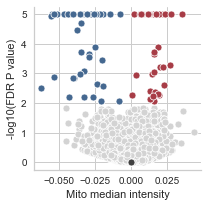

In [333]:
fdrthresh = .01
#meanthresh = .15
# meanthresh2 = 2*meanthresh
topn = 50
sev = pd.read_pickle('../Data/m40-m42/goodcellsgrped_mito.pkl')
sev = sev[sev.index.isin(grped.gene_og)] ### for comparison
#grped_pex_max.pkl')
sev['mean'] =  sev['mean']
mitodowngenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
mitoupgenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(sev['mean'], -np.log10(sev.fdr_bh_adj_p), c=mcolors.to_rgba('#d3d3d3'))
#sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index == "nontargeting"]['mean'], -np.log10(sev[sev.index== "nontargeting"].fdr_bh_adj_p), 
                c = mcolors.to_rgba('#404040'))
# sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index.isin(mitodowngenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(mitodowngenesvolcano)].fdr_bh_adj_p), c = pal[1])
sns.scatterplot(sev[sev.index.isin(mitoupgenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(mitoupgenesvolcano)].fdr_bh_adj_p), c = pal[0])
# sns.scatterplot(sev[sev.index.isin(pexdowngenestf)]['mean'], 
#                 -np.log10(sev[sev.index.isin(pexdowngenestf)].fdr_bh_adj_p), c = pal[2])

sns.despine(top = True, right = True)
plt.xlabel('Mito median intensity')
plt.ylabel('-log10(FDR P value)')
#plt.savefig('../Figures/m40-42_transfer/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

In [342]:
sev[sev.index == "MTOR"]

mean  n_sg  fisher_combined_chi  2_sided_p_value  \
gene_symbol                                                         
MTOR         0.018474   3.0            13.873312         0.031084   

             fdr_bh_adj_p  significant  
gene_symbol                             
MTOR             0.313909        False

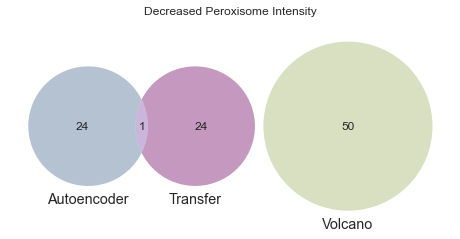

In [334]:
venn3([set(mitoupgenesvolcano), set(aeup), set(tfup)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Decreased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_mito_max_up_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

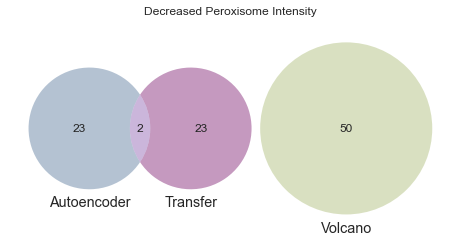

In [335]:
venn3([set(mitodowngenesvolcano), set(aedown), set(tfdown)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Decreased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_mito_max_down_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

### pex

In [4]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch6_grped_sgonly_goodcells.hdf'
grped = grp_df(loc)
gphate_pex_tf, gop_pex_tf = calc_phate(grped, colstart = 'cnn')
gumap_pex_tf = calc_umap(grped, colstart = 'cnn')

Calculating PHATE...
  Running PHATE on 19239 observations and 1228 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.28 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.30 seconds.
    Calculating affinities...
    Calculated affinities in 0.20 seconds.
  Calculated graph and diffusion operator in 12.87 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.82 seconds.
    Calculating KMeans...
    Calculated KMeans in 23.71 seconds.
  Calculated landmark operator in 27.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.56 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 227.17 seconds.
Calculated PHATE in 267.69 seconds.


In [5]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
grped = grp_df(loc)
gphate_pex_ae, gop_pex_ae = calc_phate(grped, colstart = 'ae')
gumap_pex_ae = calc_umap(grped, colstart = 'ae')

Calculating PHATE...
  Running PHATE on 19239 observations and 1027 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 15.95 seconds.
    Calculating affinities...
    Calculated affinities in 0.73 seconds.
  Calculated graph and diffusion operator in 18.36 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.41 seconds.
    Calculating KMeans...
    Calculated KMeans in 22.48 seconds.
  Calculated landmark operator in 26.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.52 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 112.29 seconds.
Calculated PHATE in 157.82 seconds.


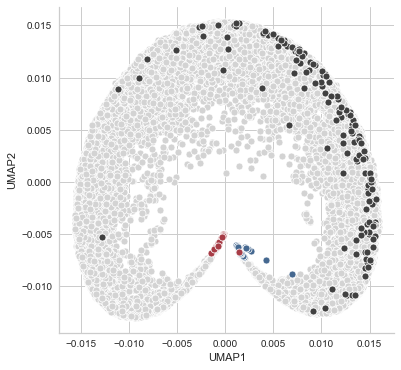

In [8]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch6_grped_sgonly_goodcells.hdf'
topn = 50
meanthresh = 0.04
colstart = 'cnn'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped,pd.DataFrame(gop_pex_tf.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_tf.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

tfup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
tfdown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-transfer/tf_df_feats_ch6_grped_sgonly_goodcells.hdf'
gpex_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_tf, name = 'pex_tf_defined',
                                                      geneslow = tfdown, geneshigh = tfup)

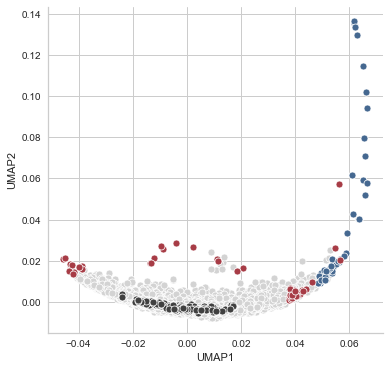

In [9]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'

## before: 25, .2
topn = 50
meanthresh = 0.04
colstart = 'phate'
grped = grp_df(loc)
#grped.loc[:,grped.columns.str.startswith(colstart)] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.startswith(colstart)])
dfu = pd.concat([pd.DataFrame(gphate_pex_ae[:,:2]),grped,pd.DataFrame(gop_pex_ae.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_ae.diff_potential.shape[1]))

nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

aeup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
aedown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
gpex_aeu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_ae, name = 'pex_ae_defined',
                                                      geneslow = aedown, geneshigh = aeup)

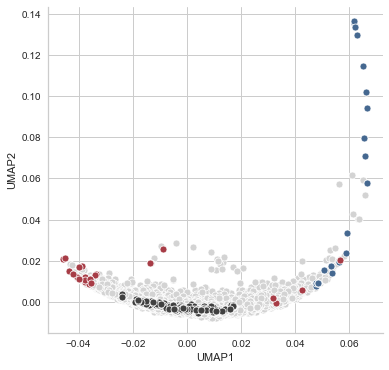

In [355]:
# loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
# topn = 25
# meanthresh = .2
# colstart = 'phate'
# grped = grp_df(loc)
# #grped.loc[:,grped.columns.str.startswith(colstart)] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.startswith(colstart)])
# dfu = pd.concat([pd.DataFrame(gphate_pex_ae[:,:2]),grped,pd.DataFrame(gop_pex_ae.diff_potential)],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_pex_ae.diff_potential.shape[1]))

# nt = dfu.loc[(dfu.gene_og == "nontargeting"),
#                   dfu.columns.str.startswith(colstart)].mean()

# dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

# aeup=dfu.query('pex_cell_max > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
# aedown=dfu.query('pex_cell_max < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

# #

# loc = '../Data/m40-m42-ae/ae_df_feats_ch6_grped_sgonly_goodcells.hdf'
# gpex_aeu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_pex_ae, name = 'pex_ae_defined',
#                                                       geneslow = aedown, geneshigh = aeup)

In [15]:
pexupgenesvolcano

Index(['GPR17', 'ELP4', 'MPI', 'PLEKHM2', 'ATP6AP2', 'WDYHV1', 'YEATS4',
       'PPIL3', 'PAPD7', 'PPCDC', 'EPC2', 'TIPRL', 'UBA5', 'IL22', 'PINX1',
       'GPR61', 'CRKL', 'UFSP2', 'NMNAT1', 'FASTKD5', 'ELP2', 'SIAH2',
       'VPS13D', 'UFL1', 'TMEM135', 'VAPA', 'UFM1', 'RBM15', 'SEM1', 'IKBKAP',
       'SLC4A7', 'CNOT9', 'DDX1', 'AHCYL1', 'ATAD1', 'UFC1', 'UBE2K',
       'ZCCHC11', 'UROS', 'PPCS', 'DNAJC8', 'SPEN', 'MCTS1', 'SAMD4B', 'PCYT2',
       'IDE', 'FEN1', 'MFF', 'DENR', 'ABCD3'],
      dtype='object', name='gene_symbol')

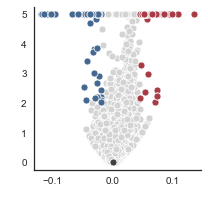

In [19]:
fdrthresh = .01
#meanthresh = .15
# meanthresh2 = 2*meanthresh
topn = 50
sns.set_style('white')
sev = pd.read_pickle('../Data/m40-m42/pex_max_volcano.pkl')
#sev = sev[sev.index.isin(grped.gene_og)] ### for comparison
#grped_pex_max.pkl')
sev['mean'] =  sev['mean']
pexdowngenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
pexupgenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(sev['mean'], -np.log10(sev.fdr_bh_adj_p), c=mcolors.to_rgba('#d3d3d3'))
#sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index == "nontargeting"]['mean'], -np.log10(sev[sev.index== "nontargeting"].fdr_bh_adj_p), 
                c = mcolors.to_rgba('#404040'))
# sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index.isin(pexdowngenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(pexdowngenesvolcano)].fdr_bh_adj_p), c = pal[1])
sns.scatterplot(sev[sev.index.isin(pexupgenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(pexupgenesvolcano)].fdr_bh_adj_p), c = pal[0])
# sns.scatterplot(sev[sev.index.isin(pexdowngenestf)]['mean'], 
#                 -np.log10(sev[sev.index.isin(pexdowngenestf)].fdr_bh_adj_p), c = pal[2])

sns.despine(top = True, right = True)
plt.xlabel(' ')
plt.ylabel(' ')
plt.savefig('../Figures/m40-42_transfer/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

In [25]:
(sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean'))[:10]

mean  n_sg  fisher_combined_chi  2_sided_p_value  \
gene_symbol                                                         
ADSS        -0.118418   1.0                  inf              0.0   
PEX13       -0.117061   4.0                  inf              0.0   
PEX2        -0.114550   4.0                  inf              0.0   
PEX14       -0.108918   3.0                  inf              0.0   
PEX1        -0.104314   4.0                  inf              0.0   
ZCCHC14     -0.103306   3.0                  inf              0.0   
PEX12       -0.099947   4.0                  inf              0.0   
PEX10       -0.096366   4.0                  inf              0.0   
PEX6        -0.095269   4.0                  inf              0.0   
PEX5        -0.067850   4.0                  inf              0.0   

             fdr_bh_adj_p  significant  
gene_symbol                             
ADSS              0.00001         True  
PEX13             0.00001         True  
PEX2              0.00001         True  
PEX14             0.00001         True  
PEX1              0.00001         True  
ZCCHC14           0.00001         True  
PEX12             0.00001         True  
PEX10             0.00001         True  
PEX6              0.00001         True  
PEX5              0.00001         True

In [22]:
pexdowngenesvolcano

Index(['ADSS', 'PEX13', 'PEX2', 'PEX14', 'PEX1', 'ZCCHC14', 'PEX12', 'PEX10',
       'PEX6', 'PEX5', 'PEX26', 'PEX11B', 'VHL', 'PEX3', 'PEX11A', 'KRTAP5-11',
       'PPRC1', 'GOLGA6L10', 'CDK13', 'SLTM', 'KEAP1', 'ZBTB17', 'UBE2D3',
       'SGF29', 'SEPHS1', 'UBAP2L', 'INPP5K', 'C19orf43', 'TASP1', 'DHX29',
       'RBM12', 'MED23', 'JUNB', 'SDR42E1', 'SIN3B', 'CHD1', 'PAPD5', 'SCAF8',
       'PEX19', 'SLC27A2', 'SAFB', 'MED16', 'IVD', 'PRUNE1', 'FAF2', 'CPSF7',
       'INTS12', 'FIS1', 'ASB7', 'GIPC1'],
      dtype='object', name='gene_symbol')

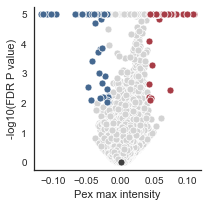

In [26]:
fdrthresh = .01
#meanthresh = .15
# meanthresh2 = 2*meanthresh
topn = 50
sns.set_style('white')
sev = pd.read_pickle('../Data/m40-m42/pex_max_volcano.pkl')
sev = sev[sev.index.isin(grped.gene_og)] ### for comparison
#grped_pex_max.pkl')
sev['mean'] =  sev['mean']
pexdowngenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
pexupgenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(sev['mean'], -np.log10(sev.fdr_bh_adj_p), c=mcolors.to_rgba('#d3d3d3'))
#sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index == "nontargeting"]['mean'], -np.log10(sev[sev.index== "nontargeting"].fdr_bh_adj_p), 
                c = mcolors.to_rgba('#404040'))
# sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index.isin(pexdowngenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(pexdowngenesvolcano)].fdr_bh_adj_p), c = pal[1])
sns.scatterplot(sev[sev.index.isin(pexupgenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(pexupgenesvolcano)].fdr_bh_adj_p), c = pal[0])
# sns.scatterplot(sev[sev.index.isin(pexdowngenestf)]['mean'], 
#                 -np.log10(sev[sev.index.isin(pexdowngenestf)].fdr_bh_adj_p), c = pal[2])

sns.despine(top = True, right = True)
plt.xlabel('Pex max intensity')
plt.ylabel('-log10(FDR P value)')
#plt.savefig('../Figures/m40-42_transfer/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

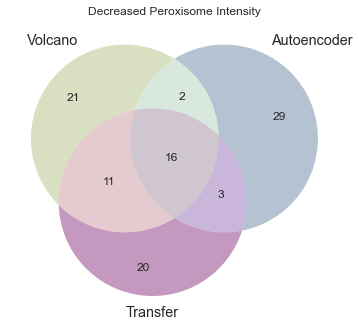

In [27]:
venn3([set(pexdowngenesvolcano), set(aedown), set(tfdown)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Decreased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_pex_max_down_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

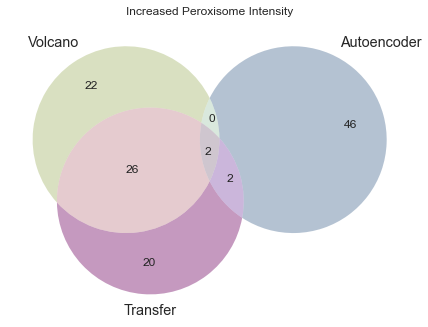

In [521]:
venn3([set(pexupgenesvolcano), set(aeup), set(tfup)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Increased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_pex_max_up_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

In [522]:
[print(p) for p in list(set(pexdowngenesvolcano) & set(tfdown) & set(aedown))]

PEX3
PEX10
SEPHS1
SLTM
PEX2
PEX26
ZCCHC14
PEX13
PEX6
TASP1
PEX1
PEX5
VHL
PEX12
PEX14
PEX11B


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [505]:
[print(p) for p in list(aeup) if p not in list(set(pexupgenesvolcano) & set(tfup))]

FAF2
SLC33A1
NUTM2G
ITGB5
GNE
DDX46
LOC107987125
RFWD2
SLC35A1
ATP2C1
FBXO11
ATP2B1
KLC3
FBXW7
LIMS1
OGDH
PPOX
DET1
TEX10
CHURC1
RIC8A
SLC35B2
KIAA0391
GRN
DHX8
TOR4A
CCL13
MIOS
PLA2R1
COQ4
NDST2
CD68
GTF2E1
LOC101060022
NENF
ARPC3
BRD2
CCDC189


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [28]:


# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=pd.Series(list(pexdowngenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/m40-m42/enrichr_pex_max_down_fdr01_top50',
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )



# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=pd.Series(list(pexupgenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/m40-m42/enrichr_pex_max_up_fdr01_top50',
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )



### sev

In [363]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch4_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_sev_tf, gop_sev_tf = calc_phate(grped, colstart = 'cnn')
gumap_sev_tf = calc_umap(grped, colstart = 'cnn')

Calculating PHATE...
  Running PHATE on 19076 observations and 1240 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.89 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.28 seconds.
  Calculated graph and diffusion operator in 12.24 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.80 seconds.
    Calculating KMeans...
    Calculated KMeans in 19.01 seconds.
  Calculated landmark operator in 22.41 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.57 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 150.30 seconds.
Calculated PHATE in 185.65 seconds.


In [362]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch4_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_sev_ae, gop_sev_ae = calc_phate(grped, colstart = 'ae')
gumap_sev_ae = calc_umap(grped, colstart = 'ae')

Calculating PHATE...
  Running PHATE on 19076 observations and 1039 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.65 seconds.
    Calculating KNN search...
    Calculated KNN search in 23.99 seconds.
    Calculating affinities...
    Calculated affinities in 1.14 seconds.
  Calculated graph and diffusion operator in 26.94 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.94 seconds.
    Calculating KMeans...
    Calculated KMeans in 27.03 seconds.
  Calculated landmark operator in 31.87 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.77 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 112.27 seconds.
Calculated PHATE in 171.91 seconds.


In [534]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch4_grped_sgonly.hdf'
topn = 40
meanthresh = .04
colstart = 'cnn'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_sev_tf[:,:2]),grped,pd.DataFrame(gop_sev_tf.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_sev_tf.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

In [543]:
topn = 30
meanthresh = .04

#tmp = dfu.query('sev_cell_median > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn]
tmp = dfu.query('(sev_cell_median < - @meanthresh) | (sev_cell_median > @meanthresh)')[['gene','distance','sev_cell_median']].sort_values(['distance'], ascending=False)[:topn]

tmp[tmp.gene.isin(['NUP155','SART1','USP39','CCAR1','PRPF31'])]

##

gene  distance  sev_cell_median
11241  NUP155  2.582031        -0.146038
17716   USP39  2.064453         0.294107
13068  PRPF31  1.918945        -0.091632
14274   SART1  1.848633        -0.049417

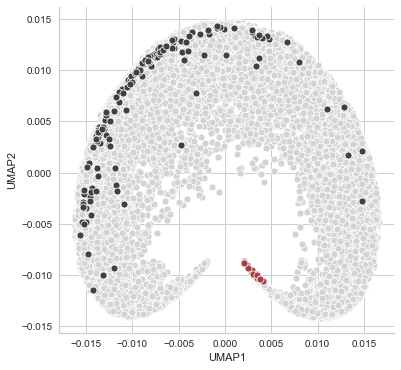

In [544]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch4_grped_sgonly.hdf'
topn = 30
meanthresh = .04
colstart = 'cnn'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_sev_tf[:,:2]),grped,pd.DataFrame(gop_sev_tf.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_sev_tf.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

#tfup=dfu.query('sev_cell_median > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
#tfdown=dfu.query('sev_cell_median < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
tfdown=dfu.query('(sev_cell_median < - @meanthresh) | (sev_cell_median > @meanthresh)')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-transfer/tf_df_feats_ch4_grped_sgonly.hdf'
gpex_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_sev_tf, name = 'sev_tf_defined',
                                                      geneslow = tfdown, geneshigh = tfdown)

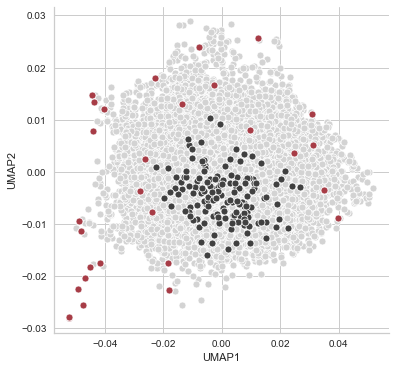

In [545]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch4_grped_sgonly.hdf'
topn = 30
meanthresh = .04
colstart = 'ae'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_sev_ae[:,:2]),grped,pd.DataFrame(gop_sev_ae.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_sev_ae.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

#aeup=dfu.query('sev_cell_median > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
#aedown=dfu=dfu.query('(sev_cell_median < - @meanthresh) | (sev_cell_median > @meanthresh)')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
aedown=dfu.query('sev_cell_median < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
#=dfu[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-ae/ae_df_feats_ch4_grped_sgonly.hdf'
gpex_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_sev_ae, name = 'sev_ae_defined',
                                                      geneslow = aedown, geneshigh = aedown)

### irf3

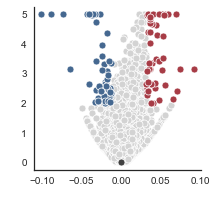

In [31]:
fdrthresh = .01
# meanthresh = .02
# meanthresh2 = 2*meanthresh
topn = 50
sev = pd.read_pickle('../Data/m40-m42/grped_sev.pkl')
sev['mean'] =  - sev['mean']
sevdowngenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
sevupgenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(sev['mean'], -np.log10(sev.fdr_bh_adj_p), c=mcolors.to_rgba('#d3d3d3'))
#sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index == "nontargeting"]['mean'], -np.log10(sev[sev.index== "nontargeting"].fdr_bh_adj_p), 
                c = mcolors.to_rgba('#404040'))
# sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index.isin(sevdowngenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(sevdowngenesvolcano)].fdr_bh_adj_p), c = pal[1])
sns.scatterplot(sev[sev.index.isin(sevupgenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(sevupgenesvolcano)].fdr_bh_adj_p), c = pal[0])
# sns.scatterplot(sev[sev.index.isin(pexdowngenestf)]['mean'], 
#                 -np.log10(sev[sev.index.isin(pexdowngenestf)].fdr_bh_adj_p), c = pal[2])

sns.despine(top = True, right = True)
plt.xlabel(' ')
plt.ylabel(' ')
plt.savefig('../Figures/m40-42_transfer/volcano_sev_median.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

In [37]:
(sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean'))[-10:]

mean  n_sg  fisher_combined_chi  2_sided_p_value  \
gene_symbol                                                         
USP8         0.053552   2.0            38.064496     1.086749e-07   
VPS11        0.054479   4.0            60.480737     3.750881e-10   
YBX1         0.055208   2.0            26.023143     3.130640e-05   
F8A3         0.055483   4.0            87.695114     1.364489e-15   
TMED10       0.059729   3.0            61.668786     2.060558e-11   
NELFB        0.066172   1.0            17.419130     1.650000e-04   
RAB14        0.070212   4.0            82.325527     1.661953e-14   
SLC25A51     0.071151   1.0            19.282247     6.500000e-05   
GPN3         0.074151   1.0            24.412145     5.000000e-06   
HGS          0.091891   1.0            24.412145     5.000000e-06   

             fdr_bh_adj_p  significant  
gene_symbol                             
USP8             0.000055         True  
VPS11            0.000010         True  
YBX1             0.002522        False  
F8A3             0.000010         True  
TMED10           0.000010         True  
NELFB            0.007117        False  
RAB14            0.000010         True  
SLC25A51         0.003894        False  
GPN3             0.000721         True  
HGS              0.000721         True

In [32]:
sevupgenesvolcano

Index(['PLA2G1B', 'HAPLN2', 'SPATA2L', 'CS', 'CDC26', 'LDB1', 'ATF1',
       'GOLGA8H', 'MED23', 'PTK2', 'FLCN', 'LOC107986794', 'ZNF574', 'SLC6A9',
       'PIP4K2C', 'UVRAG', 'SLC6A13', 'PPCDC', 'F8A1', 'VAC14', 'LOC105369274',
       'ZNHIT3', 'MEF2BNB', 'BIRC6', 'F8A2', 'ITGB5', 'ATP6V0B', 'LAMTOR2',
       'ITGAV', 'LOC653513', 'ILK', 'EIF4B', 'CRKL', 'LAMTOR3', 'RAPGEF1',
       'ARF3', 'HTT', 'PPCS', 'TARDBP', 'ATP2B1', 'USP8', 'VPS11', 'YBX1',
       'F8A3', 'TMED10', 'NELFB', 'RAB14', 'SLC25A51', 'GPN3', 'HGS'],
      dtype='object', name='gene_symbol')

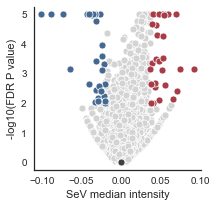

In [39]:
fdrthresh = .01
# meanthresh = .02
# meanthresh2 = 2*meanthresh
topn = 30
sev = pd.read_pickle('../Data/m40-m42/grped_sev.pkl')
sev['mean'] =  - sev['mean']
sevdowngenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
sevupgenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(sev['mean'], -np.log10(sev.fdr_bh_adj_p), c=mcolors.to_rgba('#d3d3d3'))
#sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index == "nontargeting"]['mean'], -np.log10(sev[sev.index== "nontargeting"].fdr_bh_adj_p), 
                c = mcolors.to_rgba('#404040'))
# sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index.isin(sevdowngenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(sevdowngenesvolcano)].fdr_bh_adj_p), c = pal[1])
sns.scatterplot(sev[sev.index.isin(sevupgenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(sevupgenesvolcano)].fdr_bh_adj_p), c = pal[0])
# sns.scatterplot(sev[sev.index.isin(pexdowngenestf)]['mean'], 
#                 -np.log10(sev[sev.index.isin(pexdowngenestf)].fdr_bh_adj_p), c = pal[2])

sns.despine(top = True, right = True)
plt.xlabel('SeV median intensity')
plt.ylabel('-log10(FDR P value)')
#plt.savefig('../Figures/m40-42_transfer/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

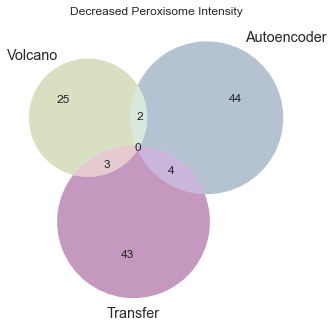

In [550]:
venn3([set(sevupgenesvolcano), set(aeup), set(tfup)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Decreased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_sev_max_up_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

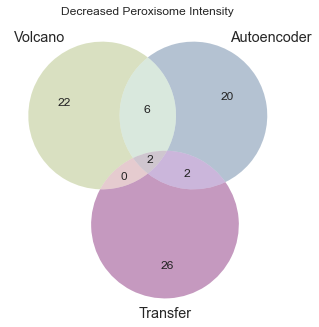

In [551]:
venn3([set(sevdowngenesvolcano), set(aedown), set(tfdown)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Decreased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_sev_max_down_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

In [552]:
[print(p) for p in list(set(sevdowngenesvolcano) & set(aedown) & set(aedown))]

COG7
GNE
CMAS
PTAR1
SLC35A1
ZCCHC6
SLC35A2
NANS


[None, None, None, None, None, None, None, None]

In [40]:


# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=pd.Series(list(sevdowngenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/m40-m42/enrichr_sev_down_fdr01_top30',
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )



# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=pd.Series(list(sevupgenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/m40-m42/enrichr_sev_up_fdr01_top30',
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )



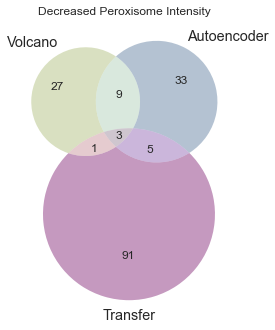

In [465]:
# venn3([set(sevupgenesvolcano), set(aeup), set(tfup)], 
#       set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
# plt.title('Decreased Peroxisome Intensity')
# plt.savefig('../Figures/F3/goodcells_sev_max_up_venn3.tif',bbox_inches = 'tight', dpi=300)
# plt.show()

# ##

In [ ]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch1_grped_sgonly.hdf'
grped = grp_df(loc)
phate_mda5_tf, op_mda5_tf = calc_phate(grped, colstart = 'cnn')
umap_mda5_tf = calc_umap(grped, colstart = 'cnn')

loc = '../Data/m40-m42-ae/ae_df_feats_ch1_grped_sgonly.hdf'
grped = grp_df(loc)
phate_mda5_ae, op_mda5_ae = calc_phate(grped, colstart = 'ae')
umap_mda5_ae = calc_umap(grped, colstart = 'ae')

loc = '../Data/m40-m42-ae/ae_df_feats_ch1_scaledto98_grped_sgonly.hdf'
grped = grp_df(loc)
phate_mda5_98, op_mda5_98 = calc_phate(grped, colstart = 'ae')
umap_mda5_98 = calc_umap(grped, colstart = 'ae')

loc = '../Data/m40-m42-ae/ae_df_feats_ch1_z_scaledto98_grped_sgonly.hdf'
grped = grp_df(loc)
phate_mda5_z98, op_mda5_z98 = calc_phate(grped, colstart = 'ae')
umap_mda5_z98 = calc_umap(grped, colstart = 'ae')

loc = '../Data/m40-m42-ae/ae_df_feats_ch1_hist_grped_sgonly.hdf'
grped = grp_df(loc)
phate_mda5_h, op_mda5_h = calc_phate(grped, colstart = 'ae')
umap_mda5_h = calc_umap(grped, colstart = 'ae')


 

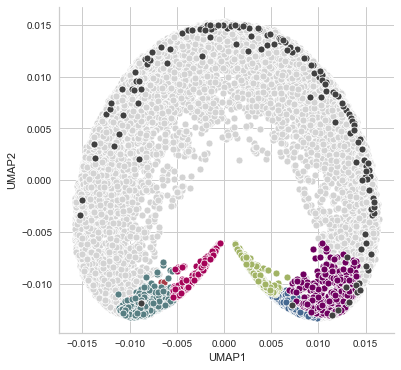

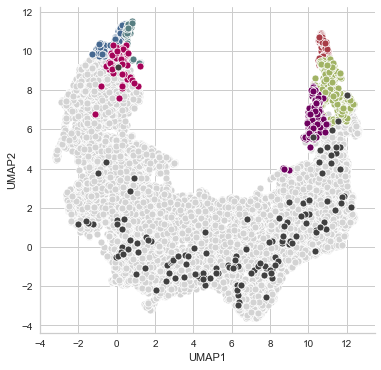

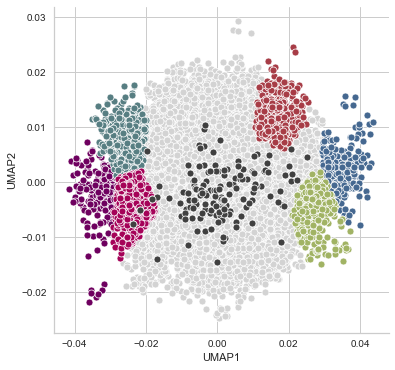

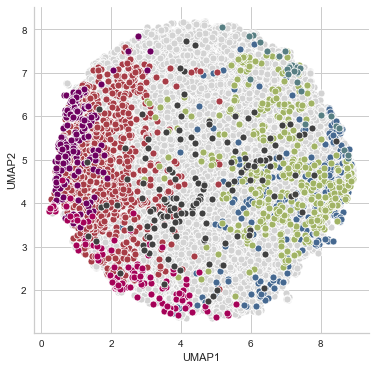

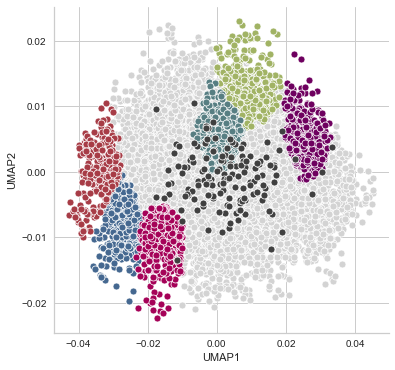

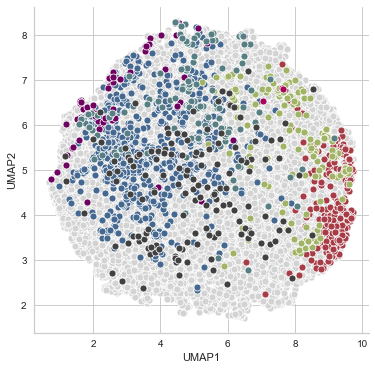

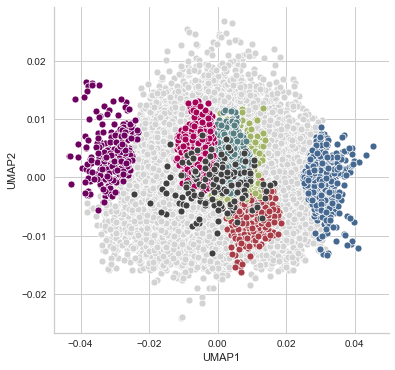

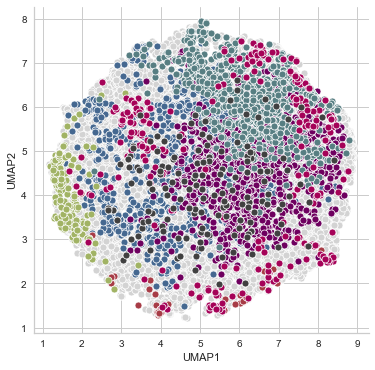

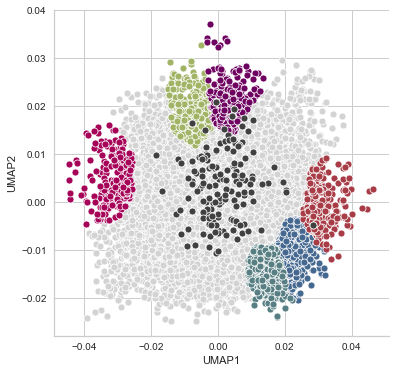

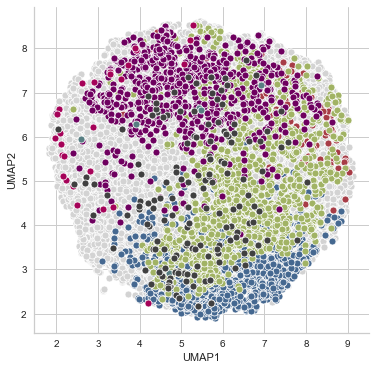

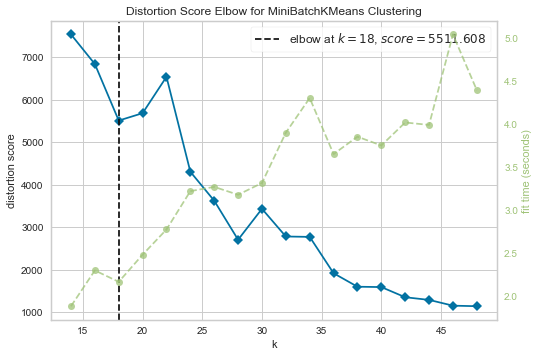

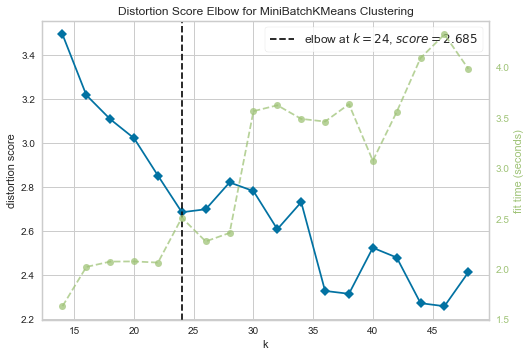

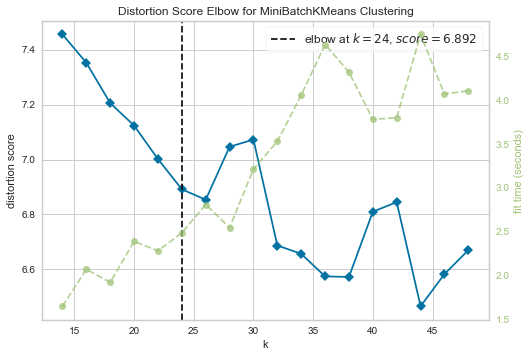

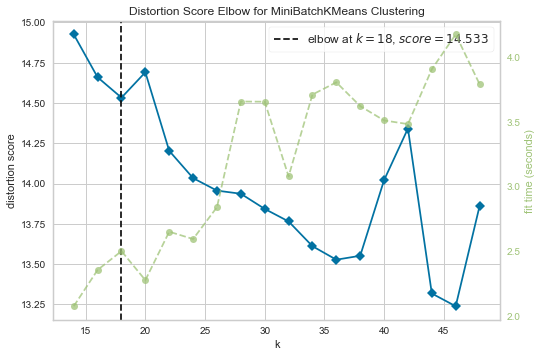

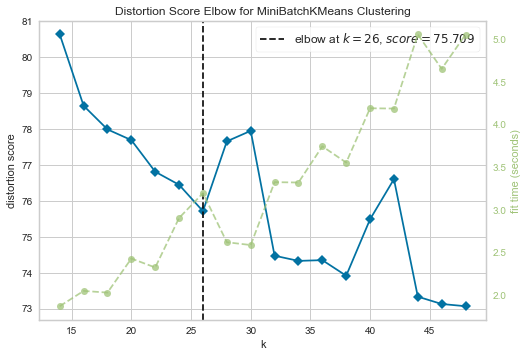

<AxesSubplot:title={'center':'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch1_grped_sgonly.hdf'
plot_phate_enrichr(loc = loc, dfphate = phate_mda5_tf, opphate = op_mda5_tf, n_clust = 30, 
                   colstart = 'cnn', feature = 'mda5_cell_min', name = 'mda5_tf')
plot_umap_enrichr(loc = loc, dfumap = umap_mda5_tf, n_clust = 30, 
                   colstart = 'cnn', feature = 'mda5_cell_min', name = 'mda5_tf')

loc = '../Data/m40-m42-ae/ae_df_feats_ch1_grped_sgonly.hdf'
plot_phate_enrichr(loc = loc, dfphate = phate_mda5_ae, opphate = op_mda5_ae, n_clust = 30, 
                   colstart = 'ae', feature = 'mda5_cell_min', name = 'mda5_ae')
plot_umap_enrichr(loc = loc, dfumap = umap_mda5_ae, n_clust = 30, 
                   colstart = 'ae', feature = 'mda5_cell_min', name = 'mda5_ae')

loc = '../Data/m40-m42-ae/ae_df_feats_ch1_scaledto98_grped_sgonly.hdf'
plot_phate_enrichr(loc = loc, dfphate = phate_mda5_98, opphate = op_mda5_98, n_clust = 30, 
                   colstart = 'ae', feature = 'mda5_cell_min', name = 'mda5_98')
plot_umap_enrichr(loc = loc, dfumap = umap_mda5_98, n_clust = 30, 
                   colstart = 'ae', feature = 'mda5_cell_min', name = 'mda5_98')

loc = '../Data/m40-m42-ae/ae_df_feats_ch1_z_scaledto98_grped_sgonly.hdf'
plot_phate_enrichr(loc = loc, dfphate = phate_mda5_z98, opphate = op_mda5_z98, n_clust = 30, 
                   colstart = 'ae', feature = 'mda5_cell_min', name = 'mda5_z98')
plot_umap_enrichr(loc = loc, dfumap = umap_mda5_z98, n_clust = 30, 
                   colstart = 'ae', feature = 'mda5_cell_min', name = 'mda5_z98')

loc = '../Data/m40-m42-ae/ae_df_feats_ch1_hist_grped_sgonly.hdf'
plot_phate_enrichr(loc = loc, dfphate = phate_mda5_h, opphate = op_mda5_h, n_clust = 30, 
                   colstart = 'ae', feature = 'mda5_cell_min', name = 'mda5_hist')
plot_umap_enrichr(loc = loc, dfumap = umap_mda5_h, n_clust = 30, 
                   colstart = 'ae', feature = 'mda5_cell_min', name = 'mda5_hist')

# Instantiate the clustering model and visualizer
loc = '../Data/m40-m42-transfer/tf_df_feats_ch1_grped_sgonly.hdf'
grped = grp_df(loc)
model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
visualizer = KElbowVisualizer(model, k=range(14,50,2))

visualizer.fit(grped.loc[:,grped.columns.str.startswith('cnn')])  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Instantiate the clustering model and visualizer
loc = '../Data/m40-m42-ae/ae_df_feats_ch1_grped_sgonly.hdf'
grped = grp_df(loc)
model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
visualizer = KElbowVisualizer(model, k=range(14,50,2))

visualizer.fit(grped.loc[:,grped.columns.str.startswith('ae')])  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Instantiate the clustering model and visualizer
loc = '../Data/m40-m42-ae/ae_df_feats_ch1_scaledto98_grped_sgonly.hdf'
grped = grp_df(loc)
model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
visualizer = KElbowVisualizer(model, k=range(14,50,2))

visualizer.fit(grped.loc[:,grped.columns.str.startswith('ae')])  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Instantiate the clustering model and visualizer
loc = '../Data/m40-m42-ae/ae_df_feats_ch1_z_scaledto98_grped_sgonly.hdf'
grped = grp_df(loc)
model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
visualizer = KElbowVisualizer(model, k=range(14,50,2))

visualizer.fit(grped.loc[:,grped.columns.str.startswith('ae')])  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Instantiate the clustering model and visualizer
loc = '../Data/m40-m42-ae/ae_df_feats_ch1_hist_grped_sgonly.hdf'
grped = grp_df(loc)
model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
visualizer = KElbowVisualizer(model, k=range(14,50,2))

visualizer.fit(grped.loc[:,grped.columns.str.startswith('ae')])  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch3_grped_sgonly.hdf'
grped = grp_df(loc)
phate_rig_tf, op_rig_tf = calc_phate(grped, colstart = 'cnn')
umap_rig_tf = calc_umap(grped, colstart = 'cnn')

loc = '../Data/m40-m42-ae/ae_df_feats_ch3_grped_sgonly.hdf'
grped = grp_df(loc)
phate_rig_ae, op_rig_ae = calc_phate(grped, colstart = 'ae')
umap_rig_ae = calc_umap(grped, colstart = 'ae')

loc = '../Data/m40-m42-ae/ae_df_feats_ch3_scaledto98_grped_sgonly.hdf'
grped = grp_df(loc)
phate_rig_98, op_rig_98 = calc_phate(grped, colstart = 'ae')
umap_rig_98 = calc_umap(grped, colstart = 'ae')

Calculating PHATE...
  Running PHATE on 19076 observations and 1040 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.67 seconds.
    Calculating KNN search...
    Calculated KNN search in 19.09 seconds.
    Calculating affinities...
    Calculated affinities in 2.93 seconds.
  Calculated graph and diffusion operator in 23.81 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.43 seconds.
    Calculating KMeans...
    Calculated KMeans in 32.82 seconds.
  Calculated landmark operator in 42.62 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.71 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 119.72 seconds.
Calculated PHATE in 186.88 seconds.


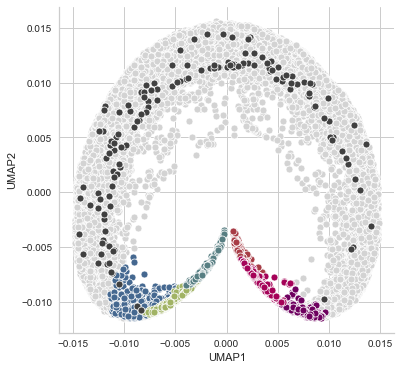

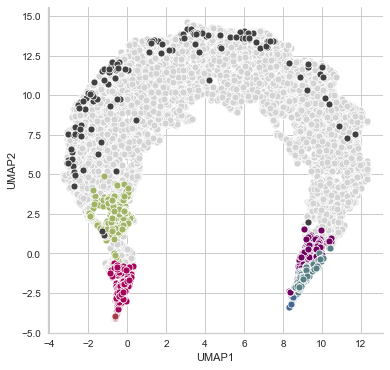

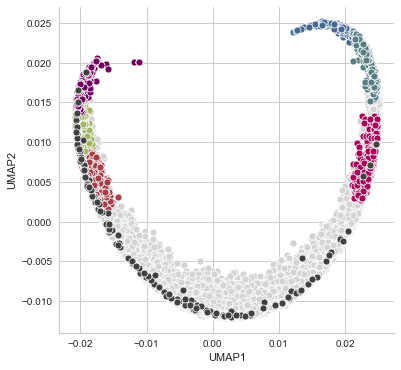

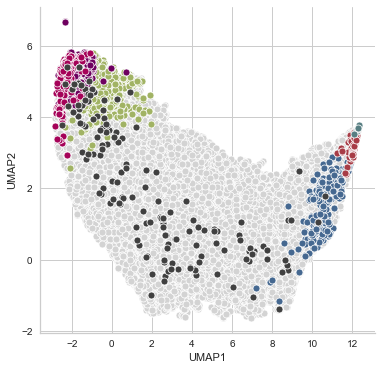

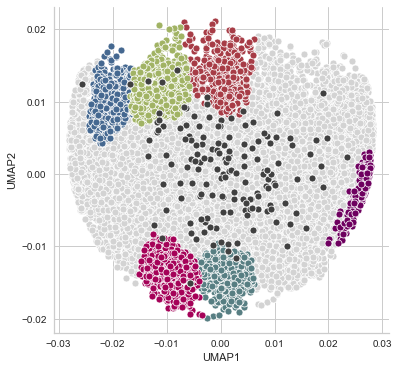

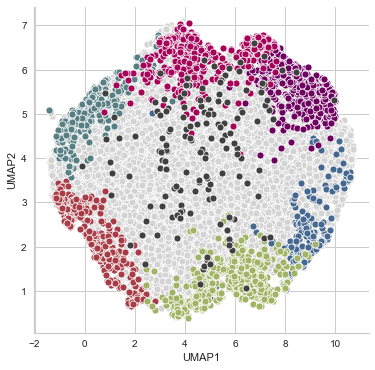

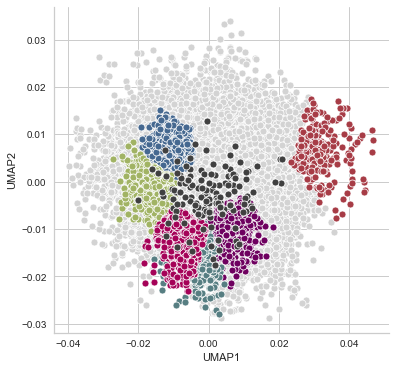

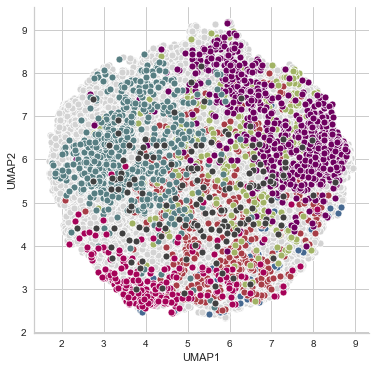

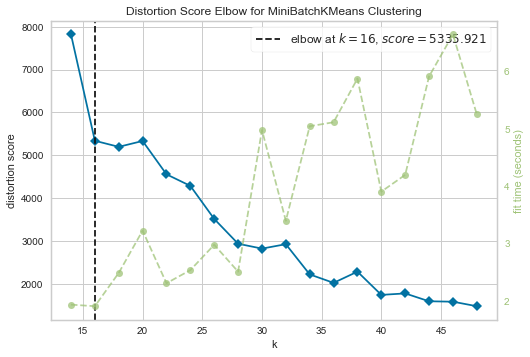

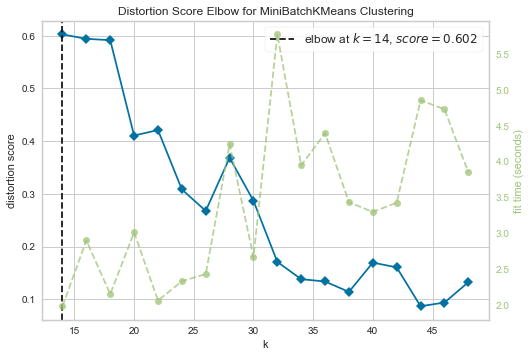

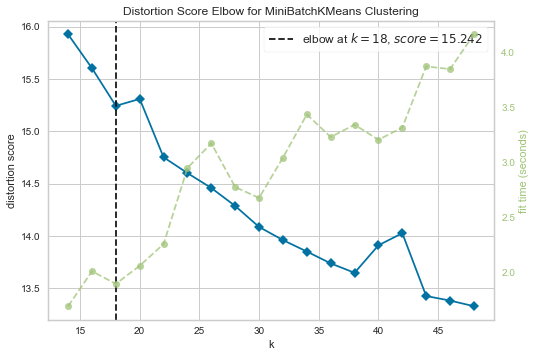

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [37]:
# loc = '../Data/m40-m42-ae/ae_df_feats_ch3_z_scaledto98_grped_sgonly.hdf'
# grped = grp_df(loc)
# phate_rig_z98, op_rig_z98 = calc_phate(grped, colstart = 'ae')
# umap_rig_z98 = calc_umap(grped, colstart = 'ae')

loc = '../Data/m40-m42-ae/ae_df_feats_ch3_hist_grped_sgonly.hdf'
grped = grp_df(loc)
phate_rig_h, op_rig_h = calc_phate(grped, colstart = 'ae')
umap_rig_h = calc_umap(grped, colstart = 'ae')


loc = '../Data/m40-m42-transfer/tf_df_feats_ch3_grped_sgonly.hdf'
plot_phate_enrichr(loc = loc, dfphate = phate_rig_tf, opphate = op_rig_tf, n_clust = 30, 
                   colstart = 'cnn', feature = 'rig_cell_median', name = 'rig_tf')
plot_umap_enrichr(loc = loc, dfumap = umap_rig_tf, n_clust = 30, 
                   colstart = 'cnn', feature = 'rig_cell_median', name = 'rig_tf')

loc = '../Data/m40-m42-ae/ae_df_feats_ch3_grped_sgonly.hdf'
plot_phate_enrichr(loc = loc, dfphate = phate_rig_ae, opphate = op_rig_ae, n_clust = 30, 
                   colstart = 'ae', feature = 'rig_cell_median', name = 'rig_ae')
plot_umap_enrichr(loc = loc, dfumap = umap_rig_ae, n_clust = 30, 
                   colstart = 'ae', feature = 'rig_cell_median', name = 'rig_ae')

loc = '../Data/m40-m42-ae/ae_df_feats_ch3_scaledto98_grped_sgonly.hdf'
plot_phate_enrichr(loc = loc, dfphate = phate_rig_98, opphate = op_rig_98, n_clust = 30, 
                   colstart = 'ae', feature = 'rig_cell_median', name = 'rig_98')
plot_umap_enrichr(loc = loc, dfumap = umap_rig_98, n_clust = 30, 
                   colstart = 'ae', feature = 'rig_cell_median', name = 'rig_98')

# loc = '../Data/m40-m42-ae/ae_df_feats_ch3_z_scaledto98_grped_sgonly.hdf'
# plot_phate_enrichr(loc = loc, dfphate = phate_rig_z98, opphate = op_rig_z98, n_clust = 30, 
#                    colstart = 'ae', feature = 'rig_cell_median', name = 'rig_z98')
# plot_umap_enrichr(loc = loc, dfumap = umap_rig_z98, n_clust = 30, 
#                    colstart = 'ae', feature = 'rig_cell_median', name = 'rig_z98')

loc = '../Data/m40-m42-ae/ae_df_feats_ch3_hist_grped_sgonly.hdf'
plot_phate_enrichr(loc = loc, dfphate = phate_rig_h, opphate = op_rig_h, n_clust = 30, 
                   colstart = 'ae', feature = 'rig_cell_median', name = 'rig_hist')
plot_umap_enrichr(loc = loc, dfumap = umap_rig_h, n_clust = 30, 
                   colstart = 'ae', feature = 'rig_cell_median', name = 'rig_hist')

# Instantiate the clustering model and visualizer
loc = '../Data/m40-m42-transfer/tf_df_feats_ch3_grped_sgonly.hdf'
grped = grp_df(loc)
model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
visualizer = KElbowVisualizer(model, k=range(14,50,2))

visualizer.fit(grped.loc[:,grped.columns.str.startswith('cnn')])  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Instantiate the clustering model and visualizer
loc = '../Data/m40-m42-ae/ae_df_feats_ch3_grped_sgonly.hdf'
grped = grp_df(loc)
model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
visualizer = KElbowVisualizer(model, k=range(14,50,2))

visualizer.fit(grped.loc[:,grped.columns.str.startswith('ae')])  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Instantiate the clustering model and visualizer
loc = '../Data/m40-m42-ae/ae_df_feats_ch3_scaledto98_grped_sgonly.hdf'
grped = grp_df(loc)
model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
visualizer = KElbowVisualizer(model, k=range(14,50,2))

visualizer.fit(grped.loc[:,grped.columns.str.startswith('ae')])  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# # Instantiate the clustering model and visualizer
# loc = '../Data/m40-m42-ae/ae_df_feats_ch3_z_scaledto98_grped_sgonly.hdf'
# grped = grp_df(loc)
# model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
# visualizer = KElbowVisualizer(model, k=range(14,50,2))

# visualizer.fit(grped.loc[:,grped.columns.str.startswith('ae')])  # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

# # Instantiate the clustering model and visualizer
# loc = '../Data/m40-m42-ae/ae_df_feats_ch3_hist_grped_sgonly.hdf'
# grped = grp_df(loc)
# model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
# visualizer = KElbowVisualizer(model, k=range(14,50,2))

# visualizer.fit(grped.loc[:,grped.columns.str.startswith('ae')])  # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

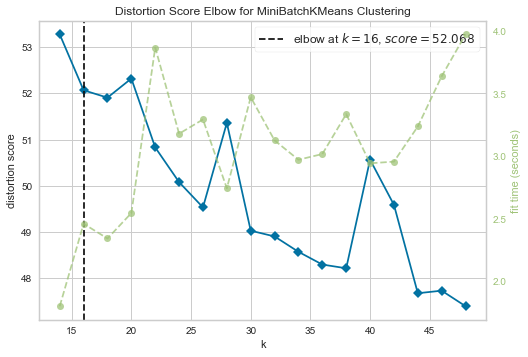

<AxesSubplot:title={'center':'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
# Instantiate the clustering model and visualizer
loc = '../Data/m40-m42-ae/ae_df_feats_ch3_hist_grped_sgonly.hdf'
grped = grp_df(loc)
model = sklearn.cluster.MiniBatchKMeans(n_init = 100, max_iter = 1000, random_state = 7)
visualizer = KElbowVisualizer(model, k=range(14,50,2))

visualizer.fit(grped.loc[:,grped.columns.str.startswith('ae')])  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [44]:

grped = pd.read_pickle('../Data/m40-m42/grped_final.pkl')
#nt = grped.loc[grped.index.str.startswith('nontargeting'),'mean_dapi_corrch2_nuclear_corr']#.mean()
#grped.columns
negnothits = grped.loc[(grped.index.isin(smallnothits)) & 
          (grped['mean_dapi_corrch2_nuclear_corr'] > 0)].index
negtruehits = grped.loc[(grped.index.isin(smalltruehits)) & 
          (grped['mean_dapi_corrch2_nuclear_corr'] > 0)].index
posnothits = grped.loc[(grped.index.isin(smallnothits)) & 
          (grped['mean_dapi_corrch2_nuclear_corr'] < 0)].index
postruehits = grped.loc[(grped.index.isin(smalltruehits)) & 
          (grped['mean_dapi_corrch2_nuclear_corr'] < 0)].index


nothitdist = grped.loc[grped.index.isin(smallnothits),
          'mean_dapi_corrch2_nuclear_corr']

hitdist = grped.loc[grped.index.isin(smalltruehits),
         'mean_dapi_corrch2_nuclear_corr']
fargenesdef = hitdist.apply(lambda x: sum(nothitdist < x))#.mean()


posnothitdist = grped.loc[grped.index.isin(posnothits),
          'mean_dapi_corrch2_nuclear_corr']

poshitdist = grped.loc[grped.index.isin(postruehits),
         'mean_dapi_corrch2_nuclear_corr']
posfargenesdef = poshitdist.apply(lambda x: sum(posnothitdist < x))#.mean()

negnothitdist = grped.loc[grped.index.isin(negnothits),
          'mean_dapi_corrch2_nuclear_corr']

neghitdist = grped.loc[grped.index.isin(negtruehits),
         'mean_dapi_corrch2_nuclear_corr']
negfargenesdef = neghitdist.apply(lambda x: sum(negnothitdist < x))#.mean()




In [45]:
design = pd.read_csv("/Users/rcarlson/Documents/lasagna_d/MAVS/poolm0_design_L1.csv")

truehits = lowhits + highhits
nothits = [g for g in pd.unique(design[design.subpool == "poolm0_0"].gene_symbol) if g not in truehits]

loc = '../Data/m40-m42-transfer/tf_df_feats_ch2_grped_sgonly.hdf'
grped = grp_df(loc)
smallnothits = grped.loc[grped.gene.isin(nothits)].gene
smalltruehits = grped.loc[grped.gene.isin(truehits)].gene
#grped.loc[:,grped.columns.str.contains('feat')] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.contains('feat')])

nt = grped.loc[grped.gene.str.startswith('nontargeting'),grped.columns.str.contains('feat')].mean()
nothitdist = grped.loc[grped.gene.isin(nothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

hitdist = grped.loc[grped.gene.isin(truehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
fargenestf = hitdist.apply(lambda x: sum(nothitdist < x))#.mean() 
## average genes at a greater distance from NT than true hits, perfect would be 276

posnothitdist = grped.loc[grped.gene.isin(posnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

poshitdist = grped.loc[grped.gene.isin(postruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
posfargenestf = poshitdist.apply(lambda x: sum(posnothitdist < x))#.mean() 


negnothitdist = grped.loc[grped.gene.isin(negnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

neghitdist = grped.loc[grped.gene.isin(negtruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
negfargenestf = neghitdist.apply(lambda x: sum(negnothitdist < x))#.mean() 


loc = '../Data/m40-m42-ae/ae_df_feats_ch2_grped_sgonly.hdf'
grped = grp_df(loc)
#grped.loc[:,grped.columns.str.contains('feat')] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.contains('feat')])

nt = grped.loc[grped.gene.str.startswith('nontargeting'),grped.columns.str.contains('feat')].mean()
nothitdist = grped.loc[grped.gene.isin(nothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

hitdist = grped.loc[grped.gene.isin(truehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
fargenesae = hitdist.apply(lambda x: sum(nothitdist < x))#.mean() 

posnothitdist = grped.loc[grped.gene.isin(posnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

poshitdist = grped.loc[grped.gene.isin(postruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
posfargenesae = poshitdist.apply(lambda x: sum(posnothitdist < x))#.mean() 

negnothitdist = grped.loc[grped.gene.isin(negnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

neghitdist = grped.loc[grped.gene.isin(negtruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
negfargenesae = neghitdist.apply(lambda x: sum(negnothitdist < x))#.mean() 



In [47]:
loc1 = '../Data/m40-m42-transfer/tf_df_feats_ch2_grped_sgonly.hdf'
loc2 = '../Data/m40-m42-ae/ae_df_feats_ch2_grped_sgonly.hdf'
grped1 = grp_df(loc1)
grped2 = grp_df(loc2)
cnnmean = grped1.loc[:,grped1.columns.str.contains('feat')].mean(axis = 0).mean()
aemean = grped2.loc[:,grped2.columns.str.contains('feat')].mean(axis = 0).mean()
grped2.loc[:,grped2.columns.str.contains('feat')] = grped2.loc[:,grped2.columns.str.contains('feat')]*cnnmean/aemean

grped = pd.merge(grped1,grped2,on = 'gene')

#grped.loc[:,grped.columns.str.contains('feat')] = StandardScaler().fit_transform(grped.loc[:,grped.columns.str.contains('feat')])
nt = grped.loc[grped.gene.str.startswith('nontargeting'),grped.columns.str.contains('feat')].mean()
nothitdist = grped.loc[grped.gene.isin(nothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

hitdist = grped.loc[grped.gene.isin(truehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
fargenescomb = hitdist.apply(lambda x: sum(nothitdist < x))#.mean() 

grped['cluster'] = umap_cluster_contains(grped, colcontains = 'feat', n_clust = 30).labels_

valhits = grped.loc[(grped.gene.isin(['DDX58','IRF3','MAVS'])), 
                  grped.columns.str.contains('feat')].mean()
print(('# + ctrl clusters'), len(pd.unique(grped[grped.gene.isin(['DDX58','IRF3','MAVS'])].cluster)))
valclust = pd.unique(grped[grped.gene.isin(['DDX58','IRF3','MAVS'])].cluster)[0]

small = grped.loc[~(grped.gene.isin(truehits)) & ~(grped.gene.isin(nothits)) & (grped.cluster == valclust)]
small['distance'] = small.loc[:,(small.columns.str.contains('feat'))].apply(lambda x: np.linalg.norm(valhits - x), axis = 1).sort_values()
genescomb = small.sort_values('distance', ascending = True)[:30].gene

posnothitdist = grped.loc[grped.gene.isin(posnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

poshitdist = grped.loc[grped.gene.isin(postruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
posfargenescomb = poshitdist.apply(lambda x: sum(posnothitdist < x))#.mean() 

negnothitdist = grped.loc[grped.gene.isin(negnothits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)

neghitdist = grped.loc[grped.gene.isin(negtruehits),
          grped.columns.str.contains('feat')].apply(lambda x: np.linalg.norm(nt - x), axis = 1)
negfargenescomb = neghitdist.apply(lambda x: sum(negnothitdist < x))#.mean() 

# + ctrl clusters 1


/Users/rcarlson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


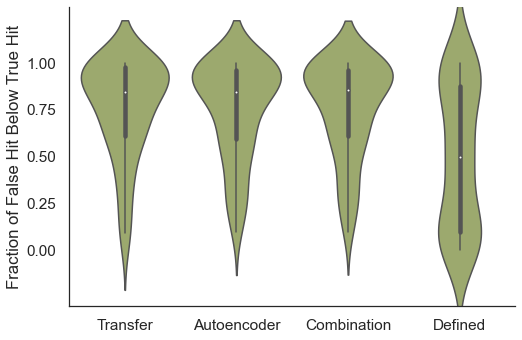

In [67]:

sns.set(font_scale=1.4)
sns.set_style("white")
df = pd.DataFrame()
df['ngenes'] = pd.concat([posfargenestf/len(posnothits), negfargenestf/len(negnothits), 
                          posfargenesae/len(posnothits), negfargenesae/len(negnothits), 
                          posfargenescomb/len(posnothits), negfargenescomb/len(negnothits),
                          posfargenesdef/len(posnothits), negfargenesdef/len(negnothits)])
df['dataset'] = ['Transfer']*63 + ['Autoencoder']*63 + ['Combination']*63 + ['Defined']*63 
sns.violinplot(data = df, x = 'dataset', y = 'ngenes', color = pal[2])
plt.xlabel('')
plt.ylabel('Fraction of False Hit Below True Hit')
plt.ylim(-.3,1.3)
plt.yticks(np.arange(0, 1.1, .25))

#sns.scatterplot(data = df, x = 'dataset', y = 'ngenes', legend=False, color = 'k',zorder=10)

sns.despine(top = True, right = True)
plt.savefig('../Figures/F3/violin_irf3_secondaryconf.tif',bbox_inches = 'tight', dpi=600)


plt.show()

### dapi

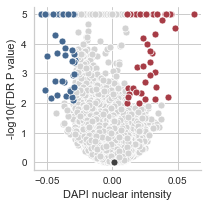

In [726]:
fdrthresh = .01
# meanthresh = .02
# meanthresh2 = 2*meanthresh

#dapi = 
topn = 50
sev = pd.read_pickle('../Data/m40-m42/grped_dapi_nuc_median.pkl')
sev = sev[sev.index.isin(grped.gene_og)] ### for comparison
#grped_pex_max.pkl')
sev['mean'] =  - sev['mean']
dapidowngenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[:topn].index)
dapiupgenesvolcano = (sev.query('fdr_bh_adj_p < @fdrthresh').sort_values('mean')[-topn:].index)

plt.figure(figsize = (3,3))
sns.scatterplot(sev['mean'], -np.log10(sev.fdr_bh_adj_p), c=mcolors.to_rgba('#d3d3d3'))
#sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index == "nontargeting"]['mean'], -np.log10(sev[sev.index== "nontargeting"].fdr_bh_adj_p), 
                c = mcolors.to_rgba('#404040'))
# sns.scatterplot(sev[sev.index.isin(sevdowngenes)]['mean'], -np.log10(sev[sev.index.isin(sevdowngenes)].fdr_bh_adj_p))
sns.scatterplot(sev[sev.index.isin(dapidowngenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(dapidowngenesvolcano)].fdr_bh_adj_p), c = pal[1])
sns.scatterplot(sev[sev.index.isin(dapiupgenesvolcano)]['mean'], 
                -np.log10(sev[sev.index.isin(dapiupgenesvolcano)].fdr_bh_adj_p), c = pal[0])
# sns.scatterplot(sev[sev.index.isin(pexdowngenestf)]['mean'], 
#                 -np.log10(sev[sev.index.isin(pexdowngenestf)].fdr_bh_adj_p), c = pal[2])

#plt.savefig('../Figures/m40-42_transfer/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')



sns.despine(top = True, right = True)
plt.xlabel('DAPI nuclear intensity')
plt.ylabel('-log10(FDR P value)')
#plt.savefig('../Figures/m40-42_transfer/volcano_pex_cell_max.tif', dpi = 600, bbox_inches = 'tight')
plt.show()
#

In [553]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch1_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_dapi_ae, gop_dapi_ae = calc_phate(grped, colstart = 'ae')
gumap_dapi_ae = calc_umap(grped, colstart = 'ae')

Calculating PHATE...
  Running PHATE on 19076 observations and 1032 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.54 seconds.
    Calculating KNN search...
    Calculated KNN search in 17.55 seconds.
    Calculating affinities...
    Calculated affinities in 0.31 seconds.
  Calculated graph and diffusion operator in 19.47 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.39 seconds.
    Calculating KMeans...
    Calculated KMeans in 19.42 seconds.
  Calculated landmark operator in 23.91 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.65 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 117.53 seconds.
Calculated PHATE in 161.58 seconds.


In [554]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch1_grped_sgonly.hdf'
grped = grp_df(loc)
gphate_dapi_tf, gop_dapi_tf = calc_phate(grped, colstart = 'cnn')
gumap_dapi_tf = calc_umap(grped, colstart = 'cnn')

Calculating PHATE...
  Running PHATE on 19076 observations and 1209 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.31 seconds.
    Calculating KNN search...
    Calculated KNN search in 16.15 seconds.
    Calculating affinities...
    Calculated affinities in 0.12 seconds.
  Calculated graph and diffusion operator in 18.62 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.90 seconds.
    Calculating KMeans...
    Calculated KMeans in 23.20 seconds.
  Calculated landmark operator in 26.90 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.57 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 211.44 seconds.
Calculated PHATE in 257.54 seconds.


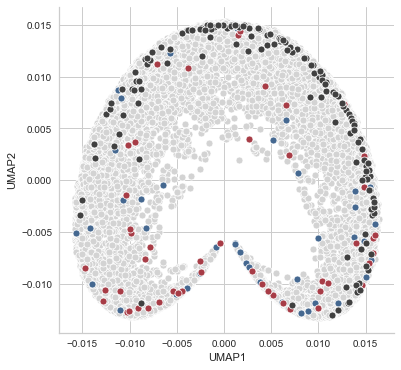

In [732]:
loc = '../Data/m40-m42-transfer/tf_df_feats_ch0_grped_sgonly.hdf'
topn = 50
meanthresh = .25
colstart = 'cnn'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_dapi_tf[:,:2]),grped,pd.DataFrame(gop_dapi_tf.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_dapi_tf.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

#tfup=dfu.query('sev_cell_median > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
#tfdown=dfu.query('sev_cell_median < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
tfup=dfu.query('(dapi_nuclear_median > @meanthresh)')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
tfdown=dfu.query('(dapi_nuclear_median < - @meanthresh) | (dapi_nuclear_median > @meanthresh)')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-transfer/tf_df_feats_ch0_grped_sgonly.hdf'
gpex_tfu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_dapi_tf, name = 'dapi_tf_defined',
                                                      geneslow = tfdown, geneshigh = tfup)

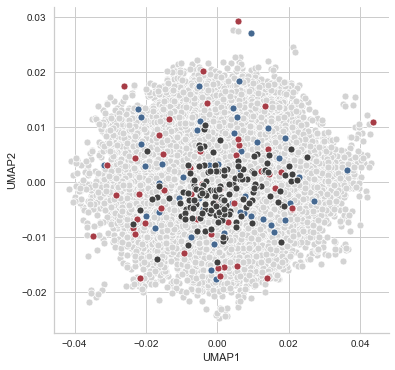

In [731]:
loc = '../Data/m40-m42-ae/ae_df_feats_ch0_grped_sgonly.hdf'
topn = 50
meanthresh = .25
colstart = 'cnn'
grped = grp_df(loc)
# dfu = pd.concat([pd.DataFrame(gphate_pex_tf[:,:2]),grped],axis = 1)
# dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) 
dfu = pd.concat([pd.DataFrame(gphate_dapi_ae[:,:2]),grped,pd.DataFrame(gop_dapi_ae.diff_potential)],axis = 1)
dfu.columns = ['UMAP1','UMAP2'] + list(grped.columns) + list(np.repeat('phate',gop_dapi_ae.diff_potential.shape[1]))


nt = dfu.loc[(dfu.gene_og == "nontargeting"),
                  dfu.columns.str.startswith(colstart)].mean()

dfu['distance'] = dfu.loc[:,dfu.columns.str.startswith(colstart)].apply(lambda x: np.linalg.norm(nt - x), axis = 1).sort_values()

#tfup=dfu.query('sev_cell_median > @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
#tfdown=dfu.query('sev_cell_median < - @meanthresh')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
aedown=dfu.query('(dapi_nuclear_median < - @meanthresh)')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene
aeup=dfu.query('(dapi_nuclear_median > @meanthresh)')[['gene','distance','pex_cell_max']].sort_values(['distance'], ascending=False)[:topn].gene

#

loc = '../Data/m40-m42-ae/ae_df_feats_ch0_grped_sgonly.hdf'
gpex_aeu = plot_phate_enrichr_definedgenes(loc = loc, dfphate = gphate_dapi_ae, name = 'dapi_ae_defined',
                                                      geneslow = aedown, geneshigh = aeup)

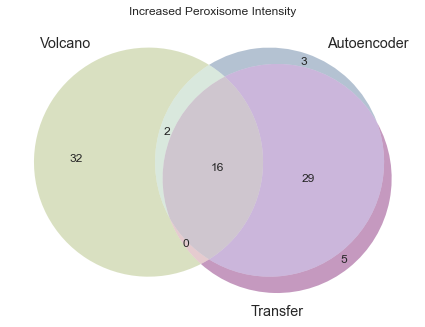

In [733]:
venn3([set(dapiupgenesvolcano), set(aeup), set(tfup)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Increased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_dapi_max_up_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

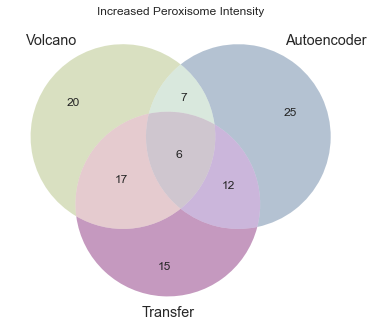

In [734]:
venn3([set(dapidowngenesvolcano), set(aedown), set(tfdown)], 
      set_labels = ['Volcano', 'Autoencoder', 'Transfer'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Increased Peroxisome Intensity')
plt.savefig('../Figures/F3/goodcells_dapi_max_down_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

In [735]:
[print(p) for p in set(set(dapidowngenesvolcano) & set(aedown) & set(tfdown))]

## NOVELISH

#  PREP

ZBTB7A
PREP
TASP1
MFI2
TRIM28
PPCS


[None, None, None, None, None, None]

In [736]:
[print(p) for p in set(set(dapiupgenesvolcano) & set(aeup) & set(tfup))]


## NOVELISH

#  FERMT2, GANAB

GANAB
FERMT2
CMAS
RBBP7
ARPC3
PHF8
DYRK1A
FBXW7
GNE
CMTR2
MSL1
FZR1
FBXO11
SLC35A1
TM9SF2
LIN37


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

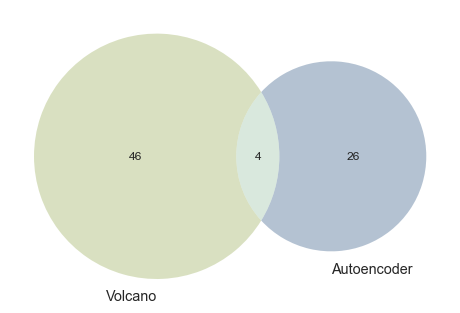

In [737]:
venn2([set(dapiupgenesvolcano), set(sevdowngenesvolcano)], 
      set_labels = ['Volcano', 'Autoencoder'], set_colors = (pal[2], pal[1])),#, pal[3]))
# plt.title('Increased Peroxisome Intensity')
# plt.savefig('../Figures/F3/goodcells_dapi_max_down_venn3.tif',bbox_inches = 'tight', dpi=300)
plt.show()

##

In [693]:
dapiupgenesvolcano[-20:]

Index(['RAPH1', 'PHF8', 'MSL1', 'COMMD3', 'ITGB5', 'CMTR2', 'FERMT2', 'FBXO11',
       'GANAB', 'CMAS', 'CCDC93', 'LIN37', 'TM9SF2', 'ILK', 'SLC35A1', 'ARPC3',
       'FZR1', 'DYRK1A', 'RBBP7', 'FBXW7'],
      dtype='object', name='gene_symbol')

In [688]:
dapidowngenesvolcano[:10]

Index(['SPOP', 'TASP1', 'ACTB', 'CCNC', 'PPCS', 'MAU2', 'TRIM28', 'MFI2',
       'EPC2', 'ZBTB7A'],
      dtype='object', name='gene_symbol')

In [706]:
[print(p) for p in set(set(dapiupgenesvolcano) & set(sevdowngenesvolcano))]

TM9SF2
SLC35A1
CMAS


[None, None, None]

In [705]:
[print(p) for p in set(set(dapidowngenesvolcano) & set(aedown) & set(tfdown))]

MFI2
PREP
PPCS


[None, None, None]

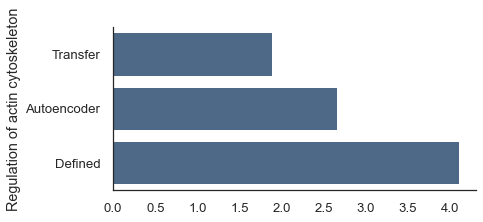

In [816]:
sns.set(font_scale=1.2) 
sns.set_style("white")
plt.figure(figsize = (6.5,3))
reslow = pd.read_table('../Data/m40-m42/lowhitssecondary/GO_Biological_Process_2018.Human.enrichr.reports.txt')
dataset = ['Transfer', 'Autoencoder', 'Defined']
pvals = [.01284,.002169,7.871e-5]
df = pd.DataFrame([dataset,pvals]).transpose()
df.columns = ['dataset', 'Adjusted P-value']
## regulation of actin cytoskeleton

# toplot = reslow[reslow['Adjusted P-value'] < .01].sort_values('Adjusted P-value',ascending=True)[:5]
sns.barplot(-np.log10(df['Adjusted P-value'].astype('float64')),df.dataset, color = pal[1])
plt.xlabel('')
plt.ylabel('Regulation of actin cytoskeleton')
sns.despine(top=True, right=True)
#plt.savefig('../Figures/F3/low_go_bp.tif', dpi = 600, bbox_inches = 'tight')

#plt.show()

In [795]:


# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=pd.Series(list(dapidowngenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/m40-m42/enrichr_dapi_down_fdr01_mean02',
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )



# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=pd.Series(list(dapiupgenesvolcano)),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/m40-m42/enrichr_dapi_up_fdr01_mean02',
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

